In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
from scipy.special import logsumexp

import sys

sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs
from populations.bbh_models import read_hdf5

from sample import sample as samp

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [38]:
param = ['mchirp','q', 'chieff', 'z']
no_params = len(param)
channel_label = 'CE'

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']

In [42]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

model_names, flow = read_models.get_models(file_path, [channel_label], params, use_flows=True, device='cpu', no_bins=[5], use_unityweights=False)
_, KDE = read_models.get_models(file_path, [channel_label], params, use_flows=False, device='cpu', use_unityweights=False)

#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


In [40]:
#_, KDE_halfbw = read_models.get_models(file_path, [channel_label], params, use_flows=False, device='cpu', use_unityweights=False, bandwidth=0.05)


100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


In [43]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_230124_100000epochs/flow_models/"
flow[channel_label].load_model(flow_path, channel_label)

In [18]:
mchirps = np.linspace(0.1,49.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps):
    sample[i] = np.asarray([m, 0.8,0.1,0.1])

sample = np.reshape(sample, (1,-1,4))

mapped_sample = flow['CE'].map_obs(sample)

p_mchirp = np.zeros((4,5,np.shape(sample)[1]))
for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_mchirp[chibid, alphaid] = flow['CE'].flow.get_logprob(sample, mapped_sample, flow['CE'].mappings, conds)

In [13]:
mchirps_kde = np.linspace(0.1,49.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps_kde):
    sample[i] = np.asarray([m, 0.8,0.1,0.1])

sample = np.reshape(sample, (1,-1,4))

p_mchirp_kde = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_mchirp_kde[chibid, alphaid] = KDE['CE'][submodels_dict[0][chibid]][submodels_dict[1][alphaid]].pdf(sample[0])

ValueError: x and y must have same first dimension, but have shapes (20,) and (100,)

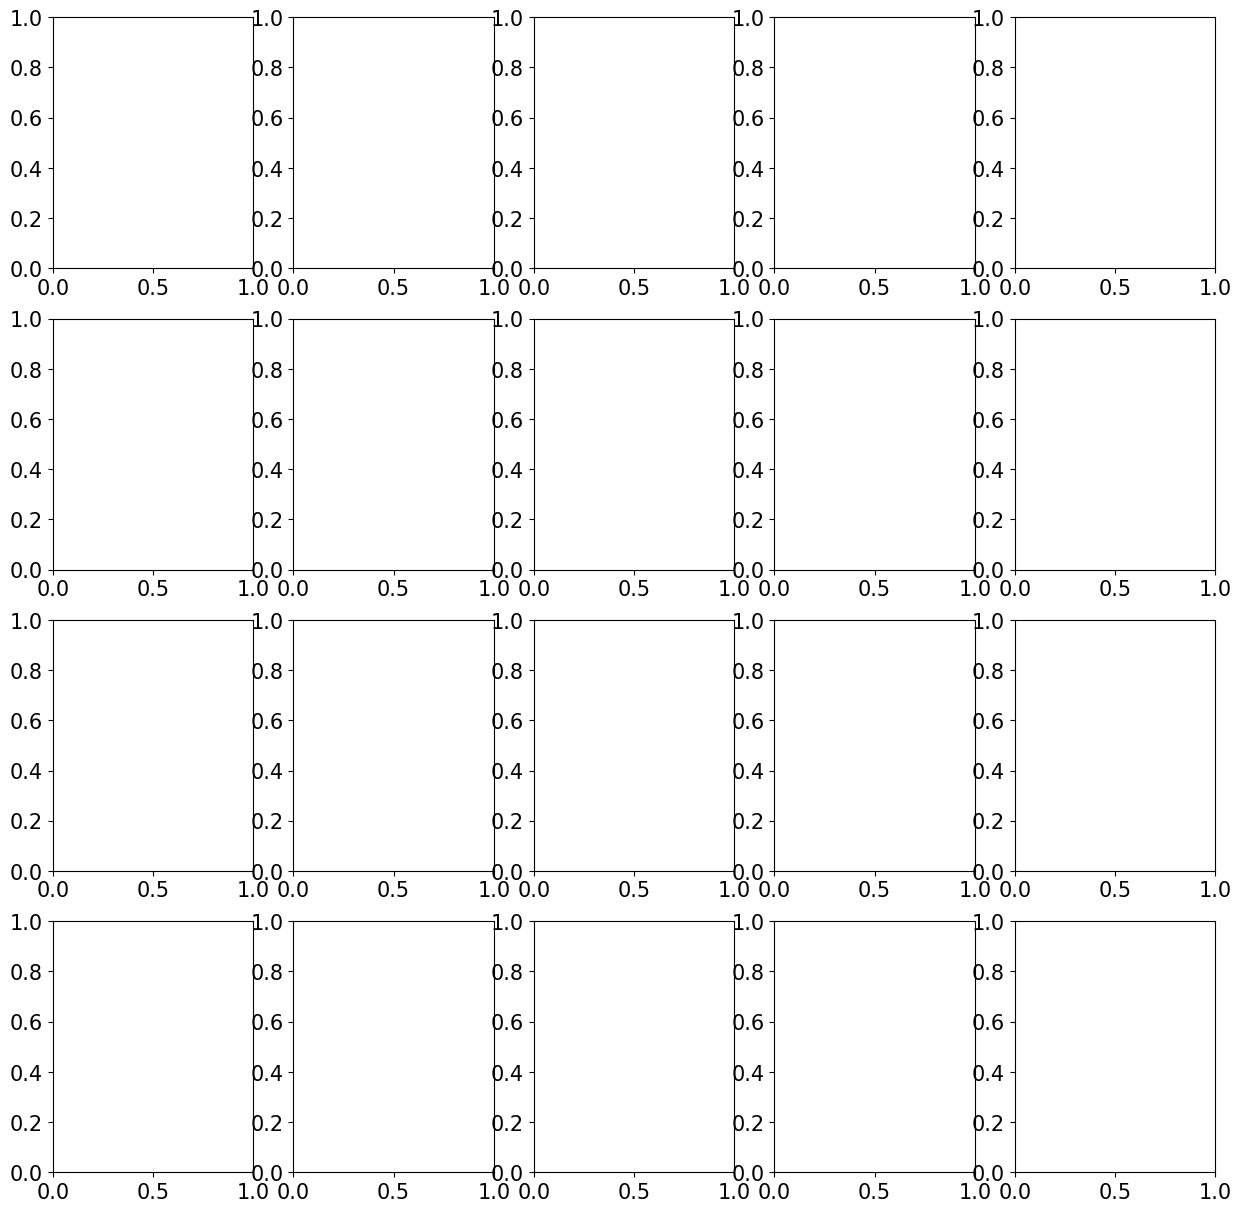

In [201]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(mchirps, np.reshape(np.exp(p_mchirp[chibid,alphaid]), -1))
        ax[chibid,alphaid].plot(mchirps_kde, np.reshape((p_mchirp_kde[chibid,alphaid]), -1))
        #ax[chibid,alphaid].plot(mchirps, np.reshape(np.exp(p_mchirp[chibid,alphaid]), -1)/np.reshape((p_mchirp_kde[chibid,alphaid]), -1))

        #plot histogram of samples around this point q=0.8,chieff=0.1,z=0.1
        bin_width = 0.05
        qs= models_dict[(chibid,alphaid)][:]['q']
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_q = np.logical_and(qs>0.8 - bin_width, qs < 0.8 + bin_width)
        bin_chieff = np.logical_and(chieffs>0.1 - 2*bin_width,  chieffs< 0.1 + 2*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_chieff), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['mchirp'], weights=weights_dict[(chibid,alphaid)][bin_conditions], color='grey', alpha=0.5, density=True)
        secax.axis('off')

        ax[chibid,alphaid].set_xlabel(fr'm_chirp')
        ax[chibid,alphaid].set_ylabel(fr'P(m_chirp|$\chi_b$={xb}, $\alpha$={a})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P(m_chirp|$\chi_b$,$\alpha$) for q=0.8, chieff=0.1, z=0.1')
fig_mchirp.tight_layout(pad=1.3)

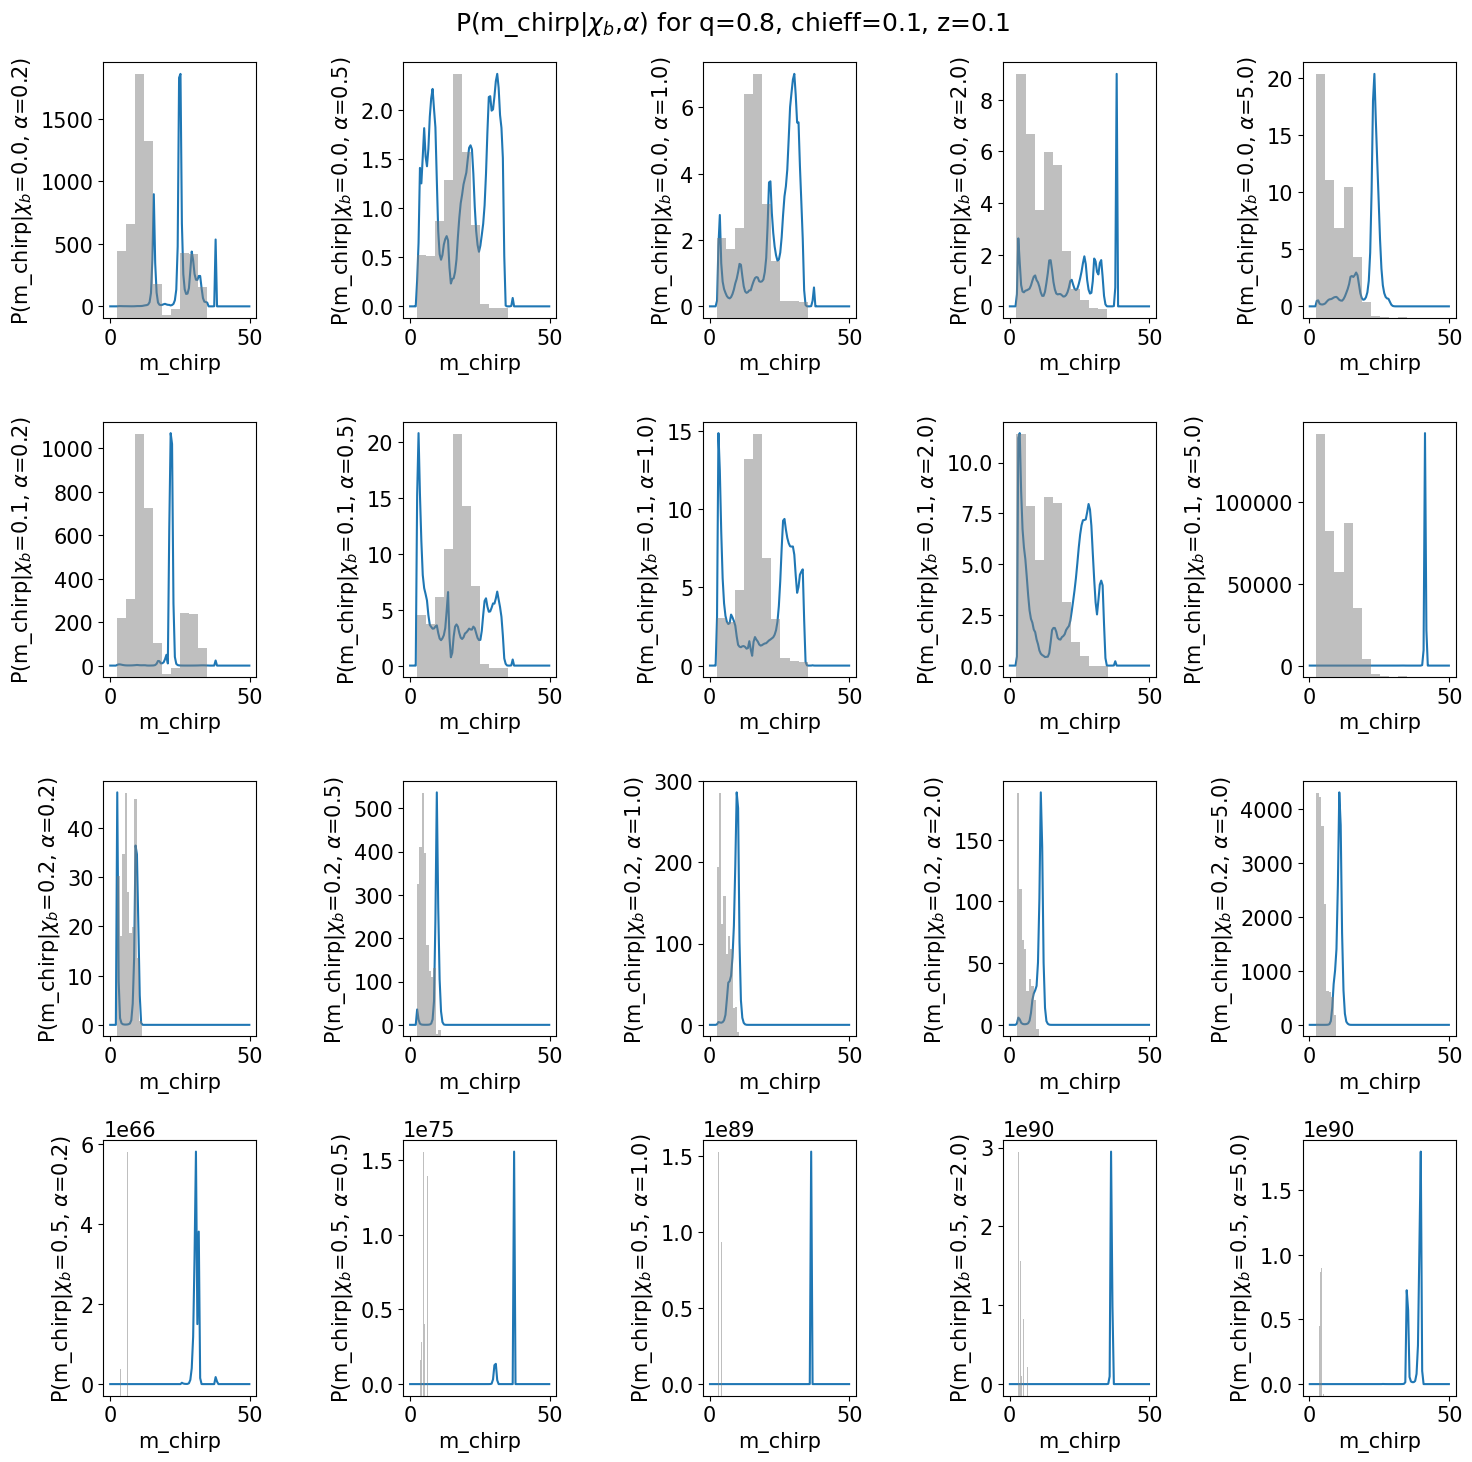

In [20]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(mchirps, np.reshape(np.exp(p_mchirp[chibid,alphaid]), -1)/np.reshape((p_mchirp_kde[chibid,alphaid]), -1))


        #plot histogram of samples around this point q=0.8,chieff=0.1,z=0.1
        bin_width = 0.05
        qs= models_dict[(chibid,alphaid)][:]['q']
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_q = np.logical_and(qs>0.8 - bin_width, qs < 0.8 + bin_width)
        bin_chieff = np.logical_and(chieffs>0.1 - 2*bin_width,  chieffs< 0.1 + 2*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_chieff), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['mchirp'], weights=weights_dict[(chibid,alphaid)][bin_conditions], color='grey', alpha=0.5, density=True)
        secax.axis('off')

        ax[chibid,alphaid].set_xlabel(fr'm_chirp')
        ax[chibid,alphaid].set_ylabel(fr'P(m_chirp|$\chi_b$={xb}, $\alpha$={a})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P(m_chirp|$\chi_b$,$\alpha$) for q=0.8, chieff=0.1, z=0.1')
fig_mchirp.tight_layout(pad=1.3)

### different set of (q,chieff,z)

In [10]:
mchirps = np.linspace(0.1,99.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps):
    sample[i] = np.asarray([m, 0.3,0.0,0.9])

sample = np.reshape(sample, (1,-1,4))

mapped_sample = flow['CE'].map_obs(sample)

p_mchirp_flow = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_mchirp_flow[chibid, alphaid] = flow['CE'].flow.get_logprob(sample, mapped_sample, flow['CE'].mappings, conds)

In [11]:
mchirps_kde = np.linspace(0.1,99.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps_kde):
    sample[i] = np.asarray([m, 0.3,0.0,0.9])

sample = np.reshape(sample, (1,-1,4))

p_mchirp_kde = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_mchirp_kde[chibid, alphaid] = KDE['CE'][submodels_dict[0][chibid]][submodels_dict[1][alphaid]].pdf(sample[0])

NameError: name 'p_mchirp_flow' is not defined

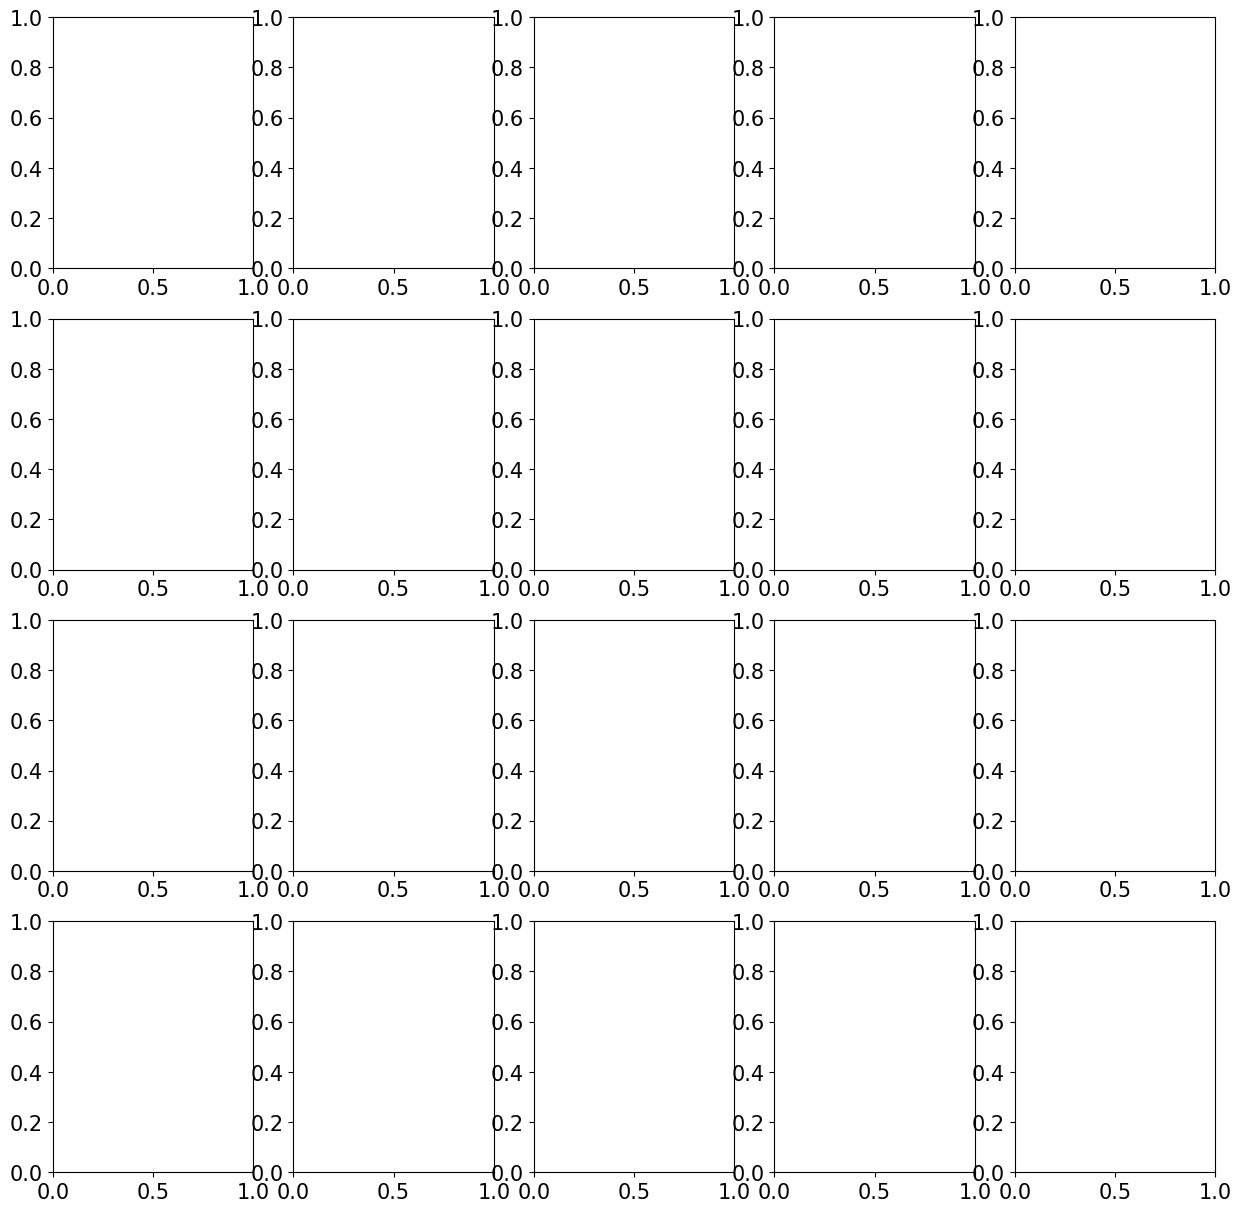

In [8]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(mchirps, np.reshape(np.exp(p_mchirp_flow[chibid,alphaid]), -1))
        ax[chibid,alphaid].plot(mchirps_kde, np.reshape((p_mchirp_kde[chibid,alphaid]), -1))


        bin_width = 0.05
        qs= models_dict[(chibid,alphaid)][:]['q']
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_q = np.logical_and(qs>0.3 - bin_width, qs < 0.3 + bin_width)
        bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
        bin_z = np.logical_and(zs>0.9 - 10*bin_width, zs < 0.9 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_chieff), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['mchirp'], weights=weights_dict[(chibid,alphaid)][bin_conditions], color='grey', alpha=0.5, density=True)
        secax.axis('off')
        ax[chibid,alphaid].set_xlabel(fr'm_chirp')
        ax[chibid,alphaid].set_ylabel(fr'P(m_chirp|$\chi_b$={xb}, $\alpha$={a})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P(m_chirp|$\chi_b$,$\alpha$) for q=0.3, chieff=0.0, z=0.9')
fig_mchirp.tight_layout(pad=1.3)


## And for q

In [13]:
qs = np.linspace(0.01,0.999,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, q in enumerate(qs):
    sample[i] = np.asarray([30., q,0.1,0.1])

sample = np.reshape(sample, (1,-1,4))

mapped_sample = flow['CE'].map_obs(sample)

p_q_flow = np.zeros((4,5,np.shape(sample)[1]))
for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_q_flow[chibid, alphaid] = flow['CE'].flow.get_logprob(sample, mapped_sample, flow['CE'].mappings, conds)

In [14]:
qs_kde = np.linspace(0.01,0.999,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, q in enumerate(qs_kde):
    sample[i] = np.asarray([30., q,0.1,0.1])

sample = np.reshape(sample, (1,-1,4))

p_q_kde = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_q_kde[chibid, alphaid] = KDE['CE'][submodels_dict[0][chibid]][submodels_dict[1][alphaid]].pdf(sample[0])

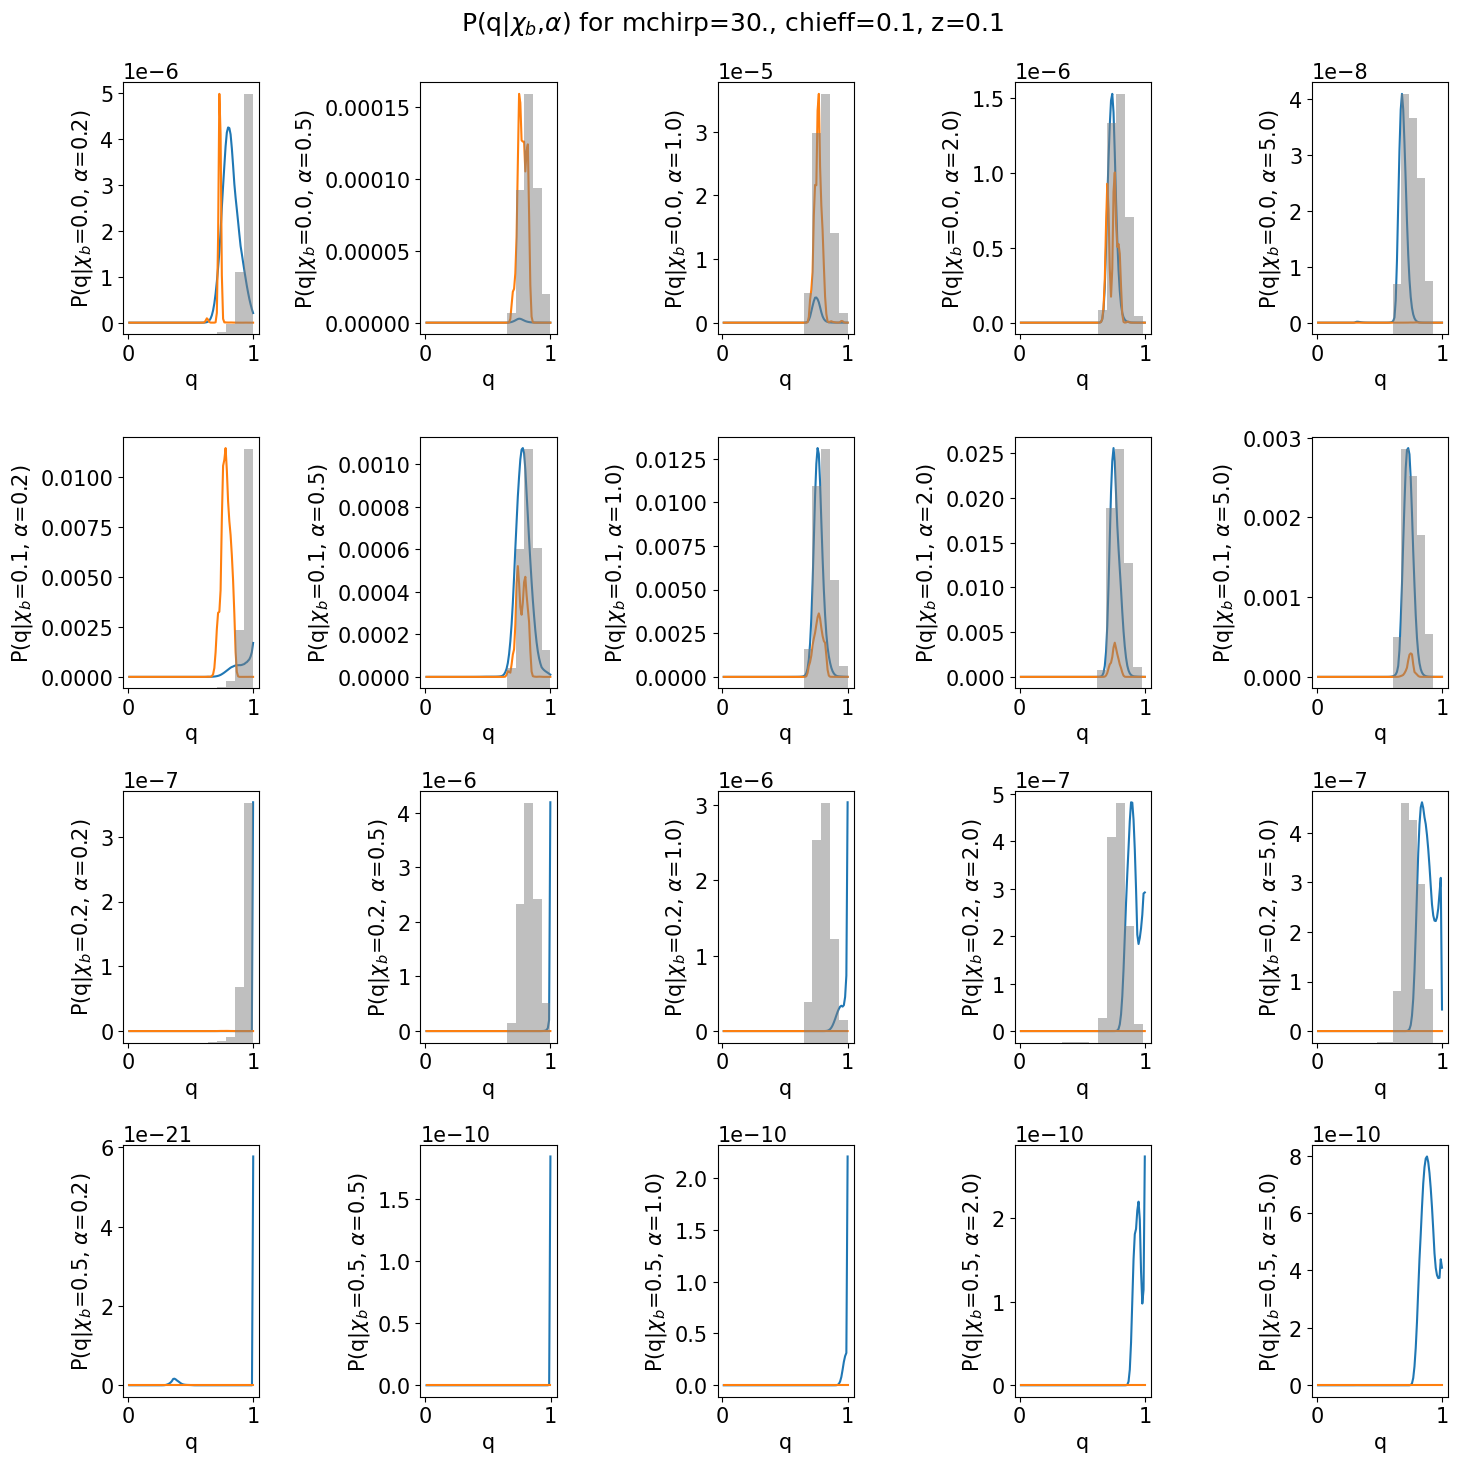

In [15]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(qs, np.reshape(np.exp(p_q_flow[chibid,alphaid]), -1))
        ax[chibid,alphaid].plot(qs_kde, np.reshape((p_q_kde[chibid,alphaid]), -1))
        bin_width = 0.15
        mchirps= models_dict[(chibid,alphaid)][:]['mchirp']
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_mchirp = np.logical_and(mchirps>30. - 100*bin_width, mchirps < 10. + 100*bin_width)
        bin_chieff = np.logical_and(chieffs>0.1 - 2*bin_width,  chieffs< 0.1 + 2*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_mchirp, bin_chieff), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['q'], weights=weights_dict[(chibid,alphaid)][bin_conditions], color='grey', alpha=0.5, density=True)
        secax.axis('off')
        #ax[chibid,alphaid].set_ylim(-50,10)
        ax[chibid,alphaid].set_xlabel(fr'q')
        ax[chibid,alphaid].set_ylabel(fr'P(q|$\chi_b$={xb}, $\alpha$={a})')
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P(q|$\chi_b$,$\alpha$) for mchirp=30., chieff=0.1, z=0.1')
fig_mchirp.tight_layout(pad=1.3)


## Likelihood from sample, not direct from model

In [44]:
mchirps = np.linspace(0.1,49.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.0,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps):
    sample[i] = np.asarray([m, 0.8,0.0,0.2])

sample = np.reshape(sample, (1,-1,4))

#mapped_sample = flow['CE'].map_obs(sample)

p_mchirp = np.zeros((4,5,np.shape(sample)[1]))
for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        for i in range(100):
            samplei = np.reshape(sample[:,i,:], (1,1,4))
            p_mchirp[chibid, alphaid, i] = samp.lnlike([chibid,alphaid], samplei, flow, submodels_dict, channels, use_flows=True, prior_pdf=None,use_reg=True)

9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909


In [45]:
mchirps_kde = np.linspace(0.1,49.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.0,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps_kde):
    sample[i] = np.asarray([m, 0.8,0.0,0.2])

sample = np.reshape(sample, (1,-1,4))

p_mchirp_kde = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        for i in range(100):
            samplei = np.reshape(sample[:,i,:], (1,1,4))
            p_mchirp_kde[chibid, alphaid, i] = samp.lnlike([chibid,alphaid], samplei, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True)

9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909


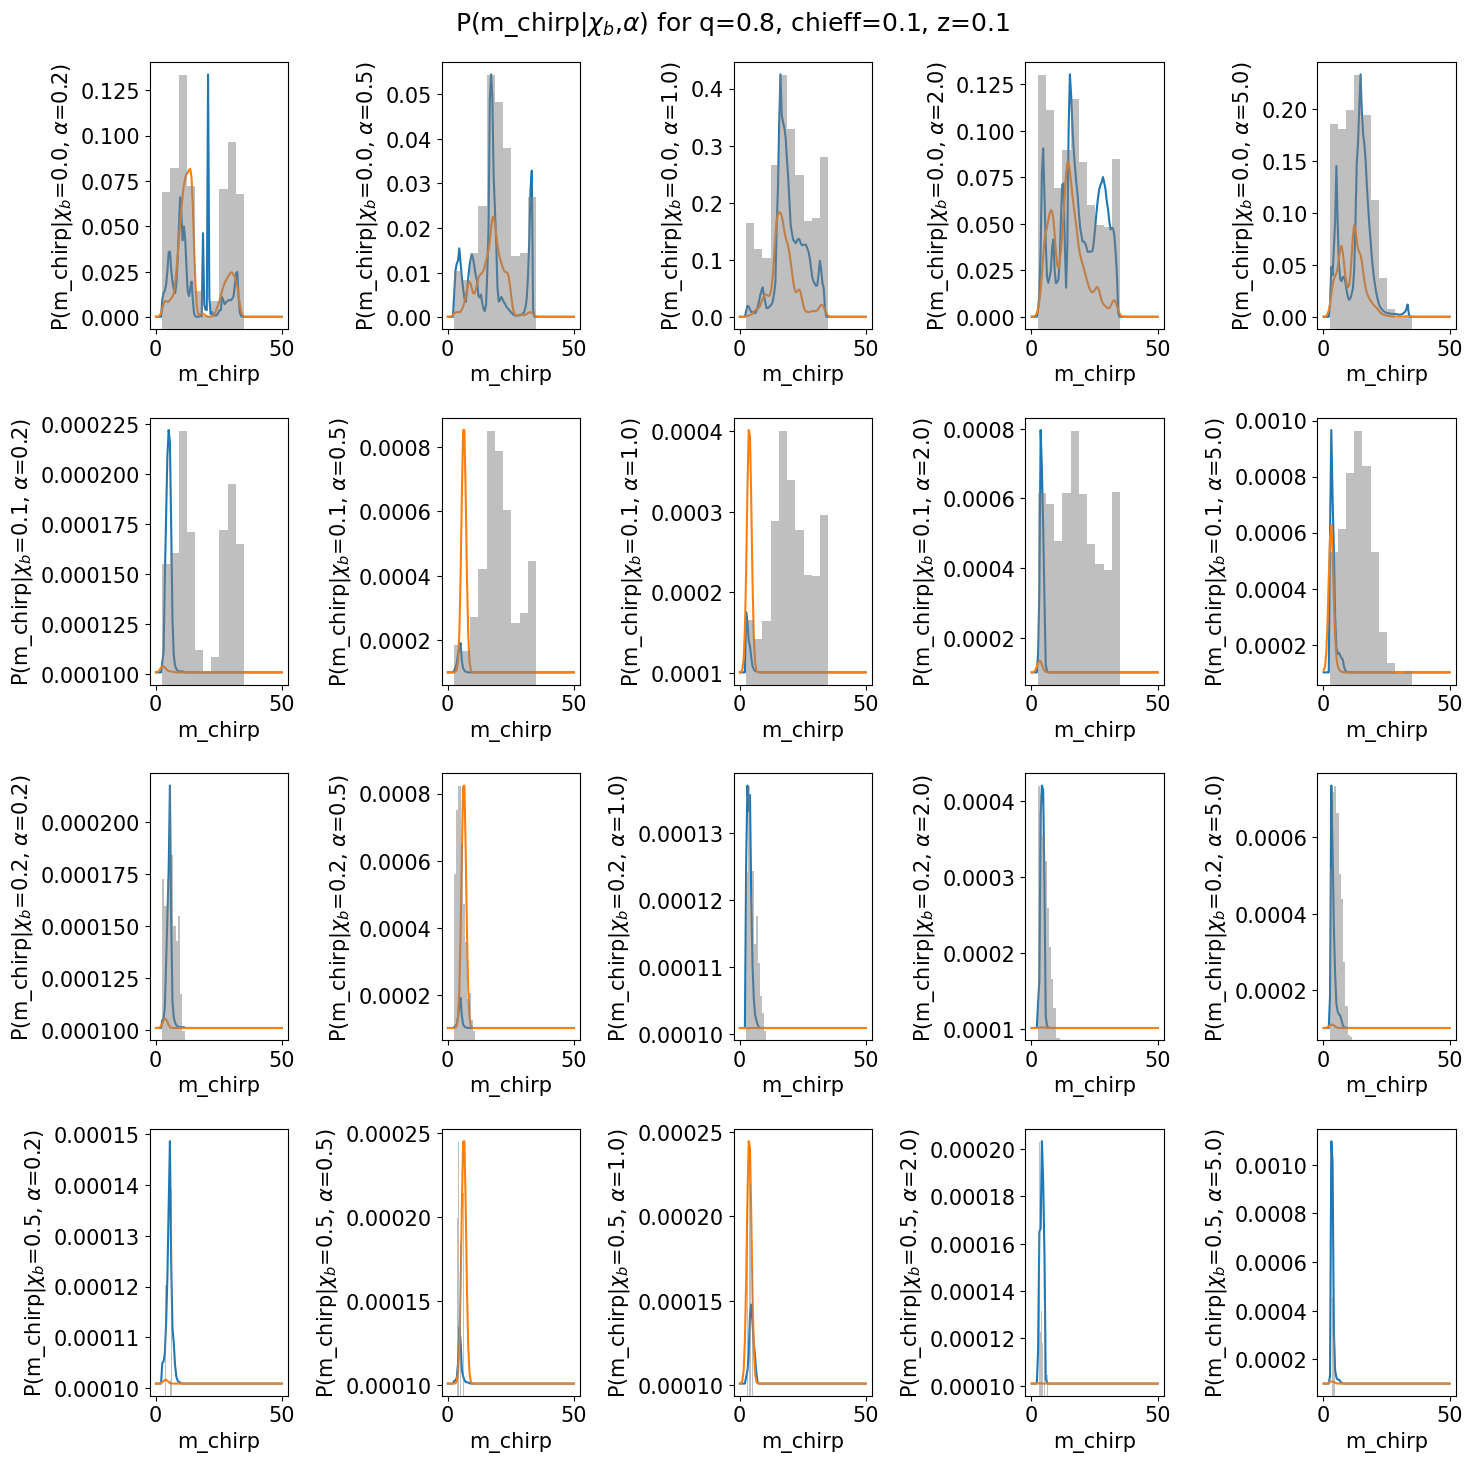

In [46]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(mchirps, np.reshape(np.exp(p_mchirp[chibid,alphaid]), -1))
        ax[chibid,alphaid].plot(mchirps_kde, np.reshape(np.exp(p_mchirp_kde[chibid,alphaid]), -1))
        #ax[chibid,alphaid].plot(mchirps, np.reshape(np.exp(p_mchirp[chibid,alphaid]), -1)/np.reshape((p_mchirp_kde[chibid,alphaid]), -1))


        #plot histogram of samples around this point q=0.8,chieff=0.1,z=0.1
        bin_width = 0.05
        qs= models_dict[(chibid,alphaid)][:]['q']
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_q = np.logical_and(qs>0.8 - bin_width, qs < 0.8 + bin_width)
        bin_chieff = np.logical_and(chieffs>0.1 - 2*bin_width,  chieffs< 0.1 + 2*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_chieff), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['mchirp'], color='grey', alpha=0.5, density=True)
        secax.axis('off')

        ax[chibid,alphaid].set_xlabel(fr'm_chirp')
        ax[chibid,alphaid].set_ylabel(fr'P(m_chirp|$\chi_b$={xb}, $\alpha$={a})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P(m_chirp|$\chi_b$,$\alpha$) for q=0.8, chieff=0.1, z=0.1')
fig_mchirp.tight_layout(pad=1.3)
#fig_mchirp.savefig('llh_ratio/slices/CE1Dmchirp_q08_chi01_z01.pdf')

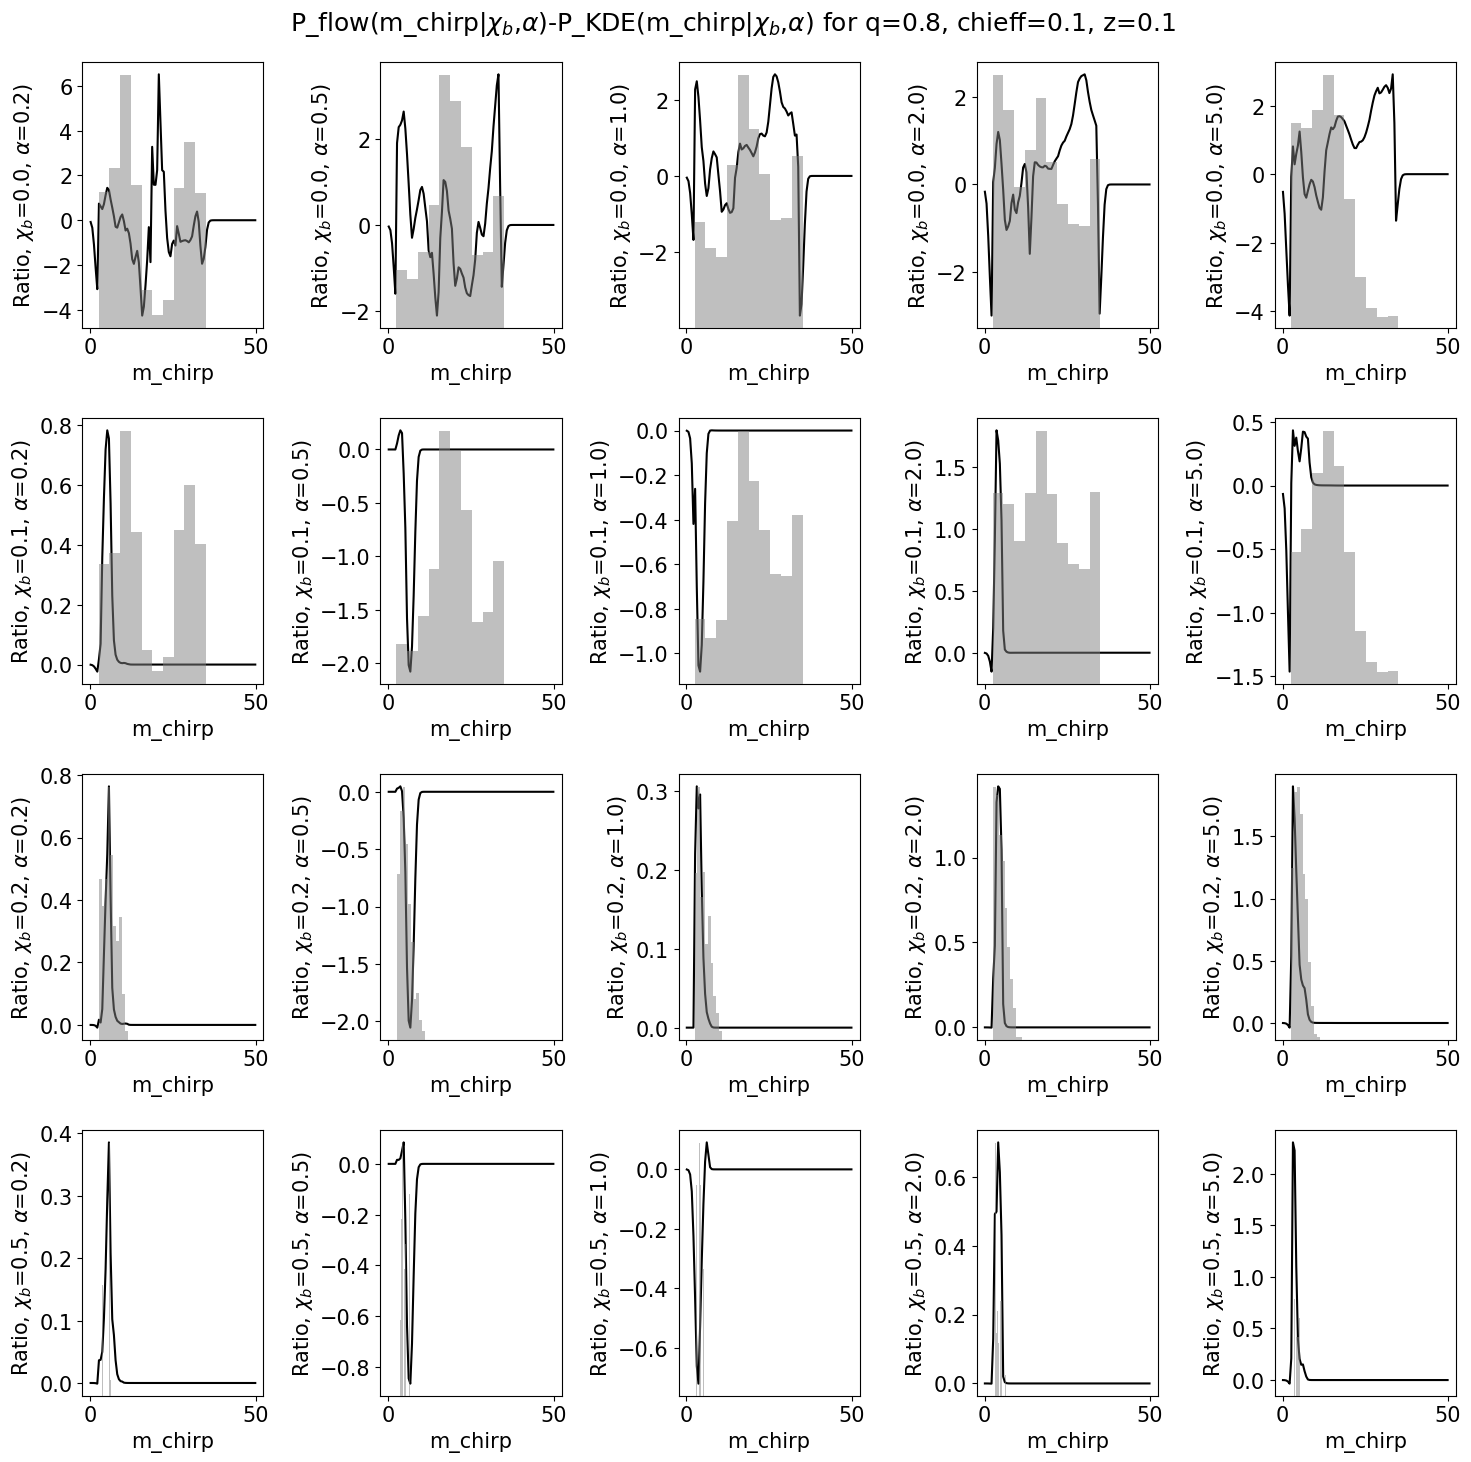

In [47]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(mchirps, np.reshape(p_mchirp[chibid,alphaid], -1)-np.reshape((p_mchirp_kde[chibid,alphaid]), -1), color='black')
        #ax[chibid,alphaid].plot(mchirps, np.reshape(p_mchirp[chibid,alphaid], -1)-np.reshape(p_mchirp_kde[chibid,alphaid], -1))


        #plot histogram of samples around this point q=0.8,chieff=0.1,z=0.1
        bin_width = 0.05
        qs= models_dict[(chibid,alphaid)][:]['q']
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_q = np.logical_and(qs>0.8 - bin_width, qs < 0.8 + bin_width)
        bin_chieff = np.logical_and(chieffs>0.1 - 2*bin_width,  chieffs< 0.1 + 2*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_chieff), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['mchirp'], color='grey', alpha=0.5, density=True)
        secax.axis('off')

        ax[chibid,alphaid].set_xlabel(fr'm_chirp')
        ax[chibid,alphaid].set_ylabel(fr'Ratio, $\chi_b$={xb}, $\alpha$={a})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P_flow(m_chirp|$\chi_b$,$\alpha$)-P_KDE(m_chirp|$\chi_b$,$\alpha$) for q=0.8, chieff=0.1, z=0.1')
fig_mchirp.tight_layout(pad=1.3)
#fig_mchirp.savefig('llh_ratio/slices/CE1Dmchirp_q08_chi01_z01_ratio.pdf')

In [51]:
chieffs = np.linspace(-0.5,.99,100)
sample = np.zeros((100,4))

for i, chi in enumerate(chieffs):
    sample[i] = np.asarray([30., 0.8,chi,0.2])

sample = np.reshape(sample, (1,-1,4))

p_chieff = np.zeros((4,5,np.shape(sample)[1]))
for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        for i in range(100):
            samplei = np.reshape(sample[:,i,:], (1,1,4))
            p_chieff[chibid, alphaid, i] = samp.lnlike([chibid,alphaid], samplei, flow, submodels_dict, channels, use_flows=True, prior_pdf=None,use_reg=True, smallest_n=9909)

9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909


In [52]:
p_chieff_kde = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        for i in range(100):
            samplei = np.reshape(sample[:,i,:], (1,1,4))
            p_chieff_kde[chibid, alphaid, i] = samp.lnlike([chibid,alphaid], samplei, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None, use_reg=True, smallest_n=9909)

9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909
9909


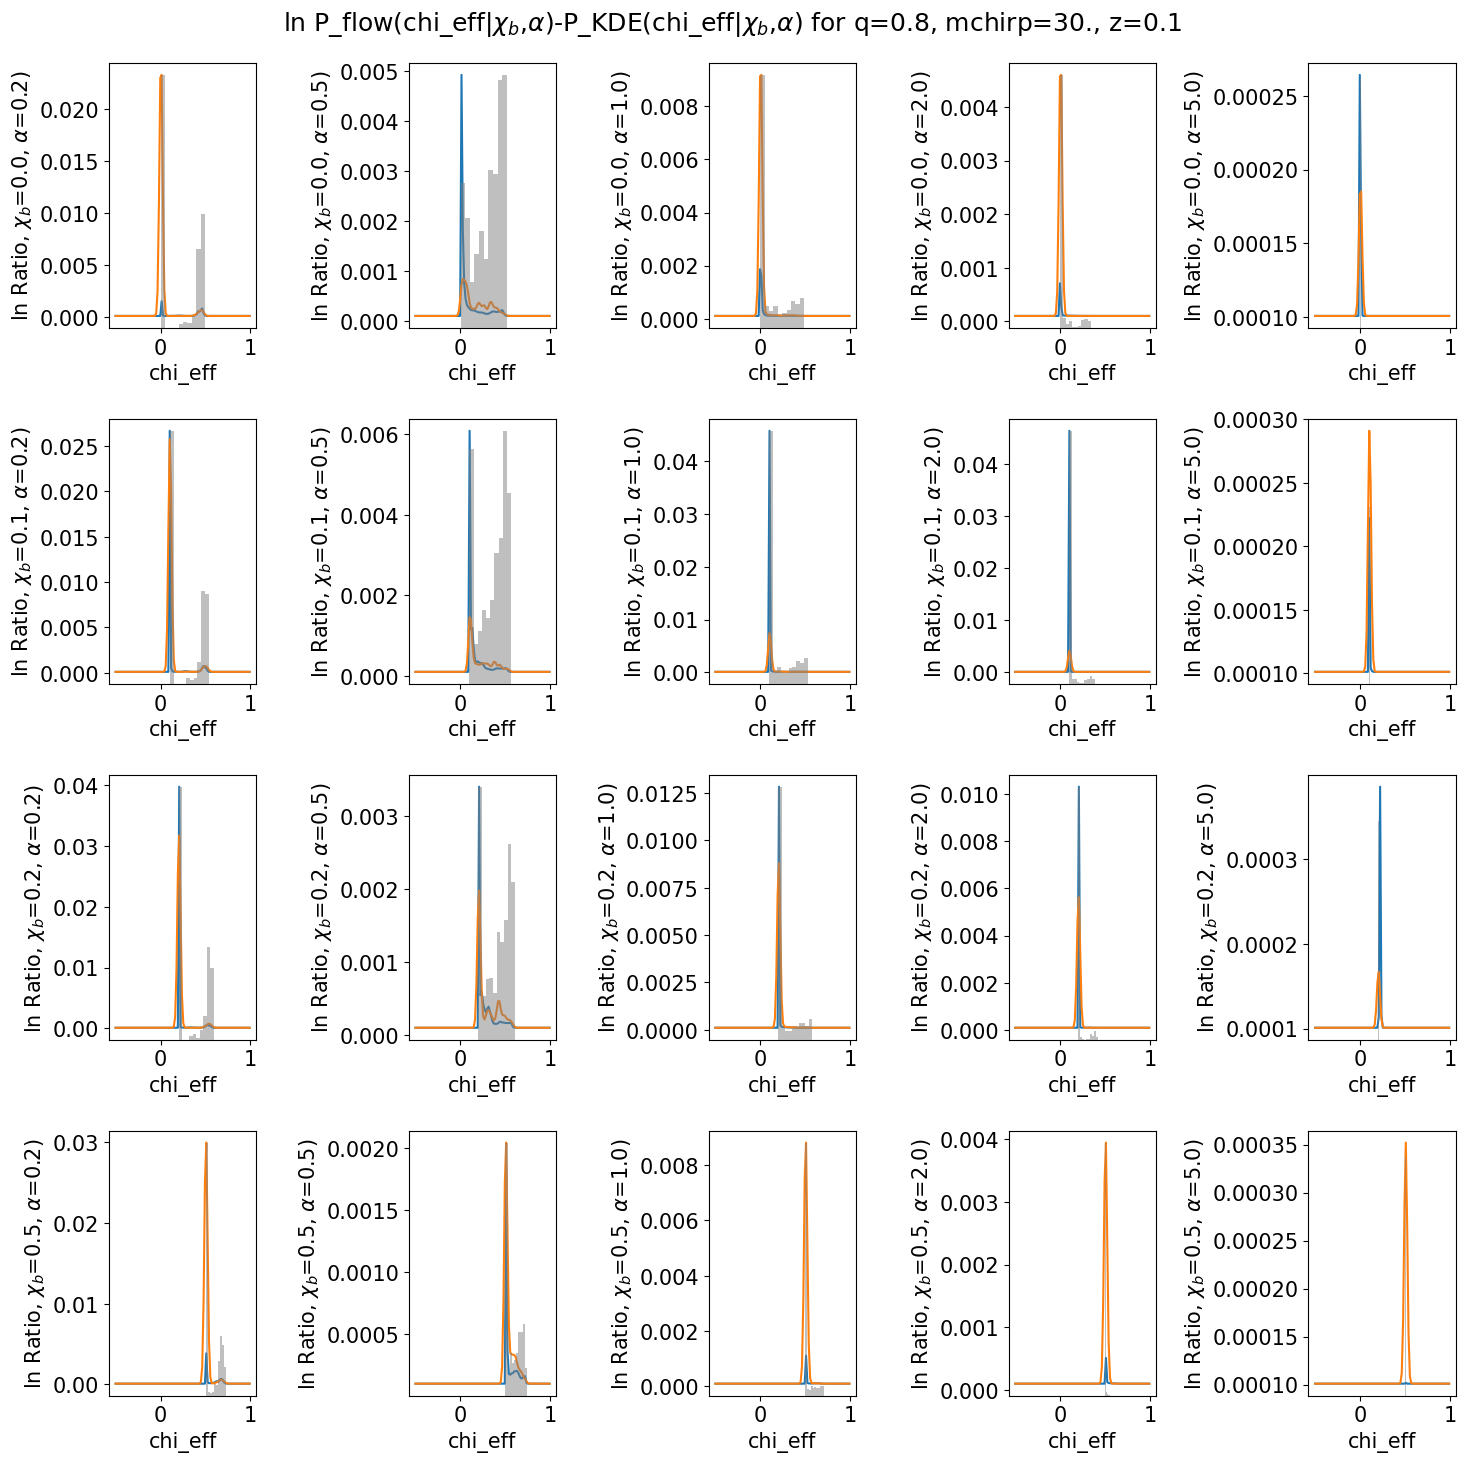

In [54]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(chieffs, np.reshape(np.exp(p_chieff[chibid,alphaid]), -1))
        ax[chibid,alphaid].plot(chieffs, np.reshape(np.exp(p_chieff_kde[chibid,alphaid]), -1))

        #plot histogram of samples around this point q=0.8,chieff=0.1,z=0.1
        bin_width = 0.05
        qs= models_dict[(chibid,alphaid)][:]['q']
        mchirps = models_dict[(chibid,alphaid)][:]['mchirp']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_q = np.logical_and(qs>0.8 - bin_width, qs < 0.8 + bin_width)
        bin_mchirp = np.logical_and(mchirps>30. - 20*bin_width,  mchirps< 30. + 20*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_mchirp), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['chieff'], color='grey', alpha=0.5, density=True)
        secax.axis('off')

        ax[chibid,alphaid].set_xlabel(fr'chi_eff')
        ax[chibid,alphaid].set_ylabel(fr'ln Ratio, $\chi_b$={xb}, $\alpha$={a})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'ln P_flow(chi_eff|$\chi_b$,$\alpha$)-P_KDE(chi_eff|$\chi_b$,$\alpha$) for q=0.8, mchirp=30., z=0.1')
fig_mchirp.tight_layout(pad=1.3)
#fig_mchirp.savefig('llh_ratio/slices/CE1Dmchirp_q08_chi01_z01_ratio.pdf')

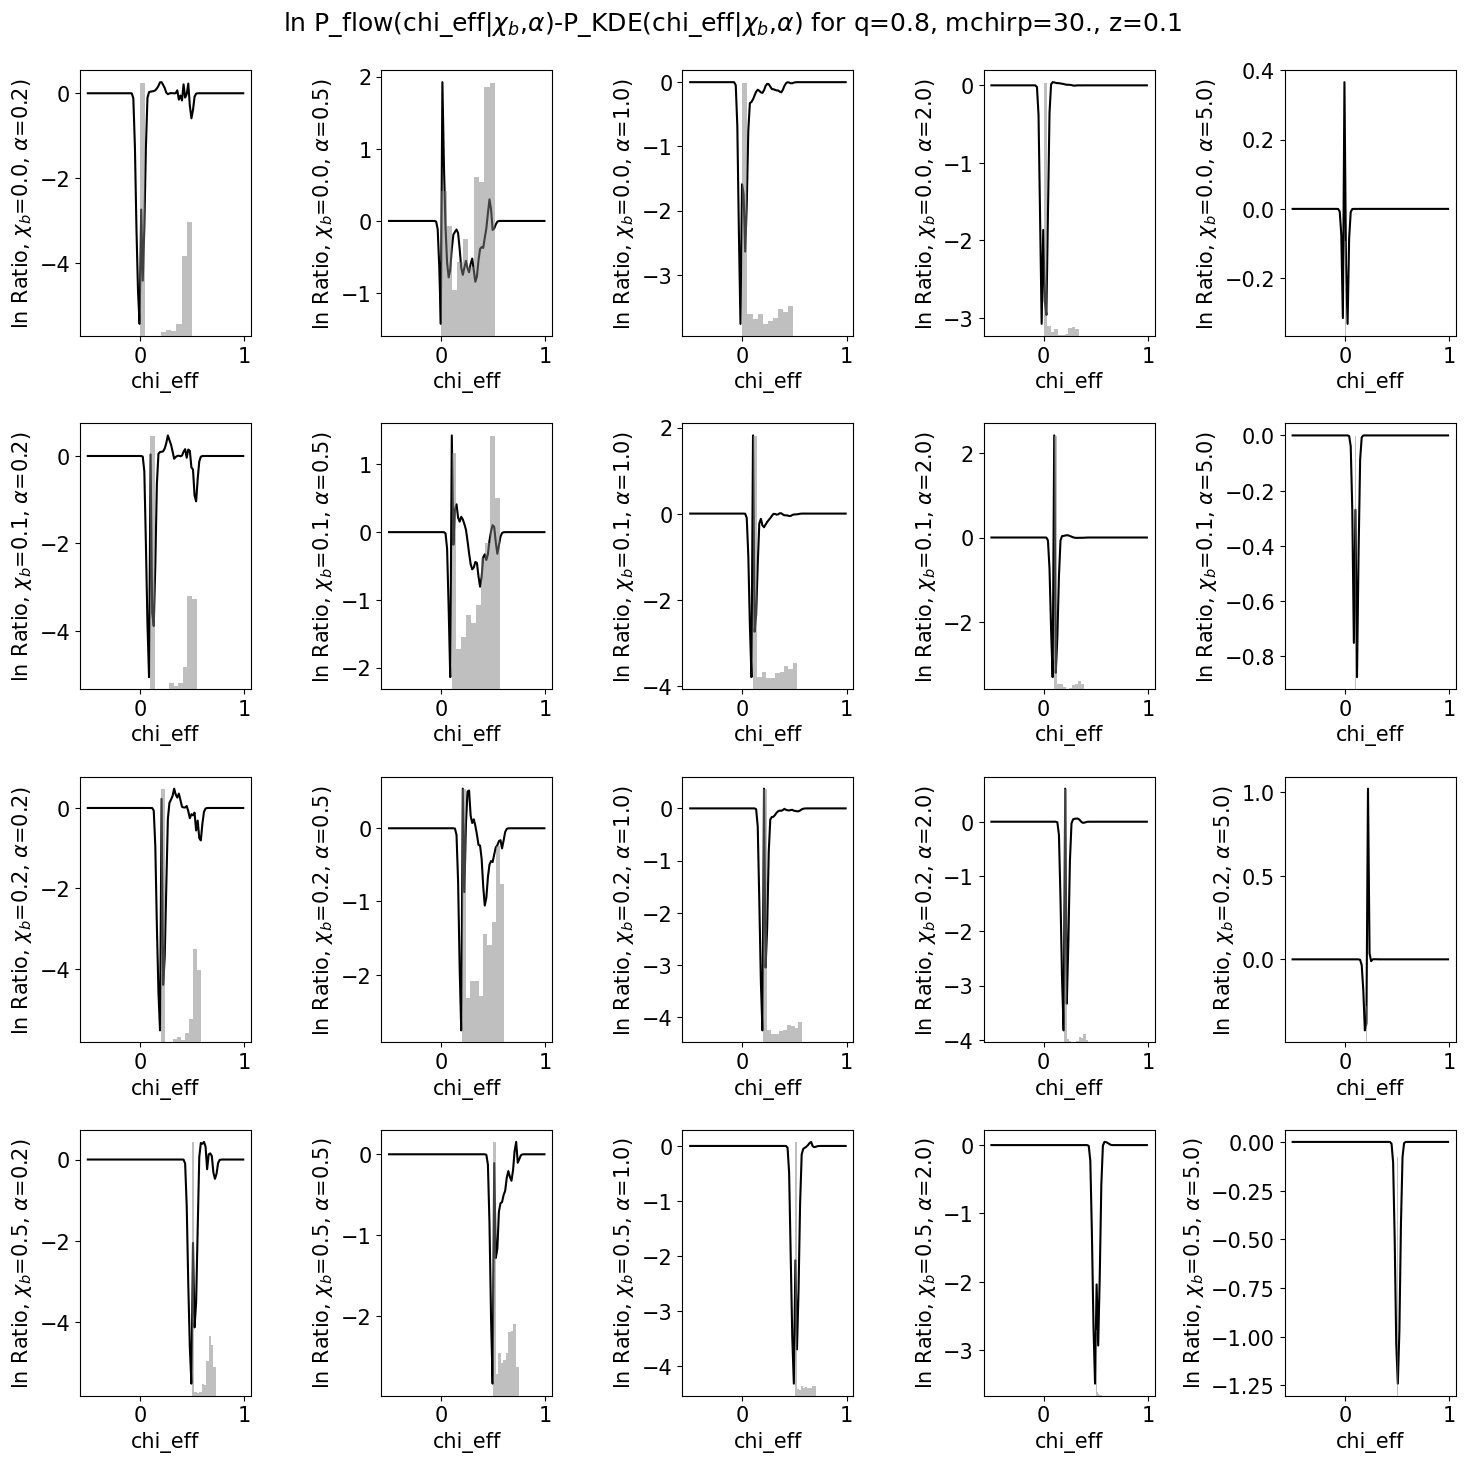

In [55]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(chieffs, np.reshape(p_chieff[chibid,alphaid], -1)-np.reshape((p_chieff_kde[chibid,alphaid]), -1), color='black')
        #ax[chibid,alphaid].plot(mchirps, np.reshape(p_mchirp[chibid,alphaid], -1)-np.reshape(p_mchirp_kde[chibid,alphaid], -1))


        #plot histogram of samples around this point q=0.8,chieff=0.1,z=0.1
        bin_width = 0.05
        qs= models_dict[(chibid,alphaid)][:]['q']
        mchirps = models_dict[(chibid,alphaid)][:]['mchirp']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_q = np.logical_and(qs>0.8 - bin_width, qs < 0.8 + bin_width)
        bin_mchirp = np.logical_and(mchirps>30. - 20*bin_width,  mchirps< 30. + 20*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_mchirp), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['chieff'], color='grey', alpha=0.5, density=True)
        secax.axis('off')

        ax[chibid,alphaid].set_xlabel(fr'chi_eff')
        ax[chibid,alphaid].set_ylabel(fr'ln Ratio, $\chi_b$={xb}, $\alpha$={a})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'ln P_flow(chi_eff|$\chi_b$,$\alpha$)-P_KDE(chi_eff|$\chi_b$,$\alpha$) for q=0.8, mchirp=30., z=0.1')
fig_mchirp.tight_layout(pad=1.3)
#fig_mchirp.savefig('llh_ratio/slices/CE1Dmchirp_q08_chi01_z01_ratio.pdf')

## 2D over mchirp-q

In [48]:
mchirps = np.linspace(0.1,49.9,20)
qs = np.linspace(0.01,0.99,20)

p_mchirpq = np.zeros((4,5,20,20))
p_mchirpq_kde = np.zeros((4,5,20,20))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        for  i, m in enumerate(mchirps):
            for j, q in enumerate(qs):
                sample = np.reshape([m, q,0.0,0.2], (1,1,4))
                p_mchirpq[chibid, alphaid, i, j] = samp.lnlike([chibid,alphaid], sample, flow, submodels_dict, channels, use_flows=True, prior_pdf=None, use_reg=True, smallest_n=990903)
                p_mchirpq_kde[chibid, alphaid, i, j] = samp.lnlike([chibid,alphaid], sample, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True, smallest_n=990903)

990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903
990903

In [33]:
np.save('llh_ratio/slices/CE2Dmchirpq_chi0_z02_p_flow_990903smallestn.npy', p_mchirpq, allow_pickle=True)
np.save('llh_ratio/slices/CE2Dmchirpq_chi0_z02_p_KDE_990903smallestn.npy', p_mchirpq_kde, allow_pickle=True)

In [27]:
strict_reg_flow = np.load('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/testing_notebooks/llh_ratio/slices/CE2Dmchirpq_chi0_z02_p_flow.npy')
strct_reg_KDE = np.load('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/testing_notebooks/llh_ratio/slices/CE2Dmchirpq_chi0_z02_p_KDE.npy')

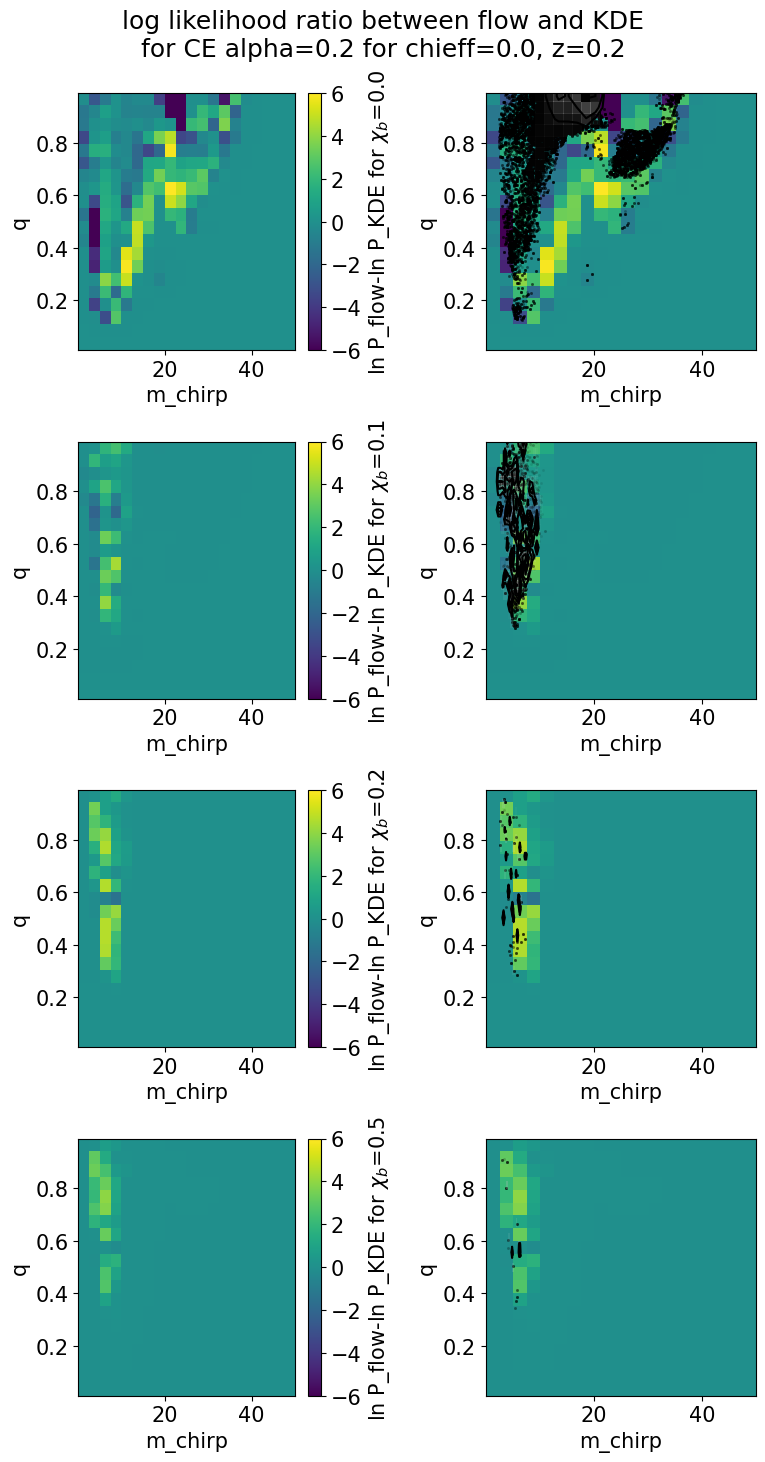

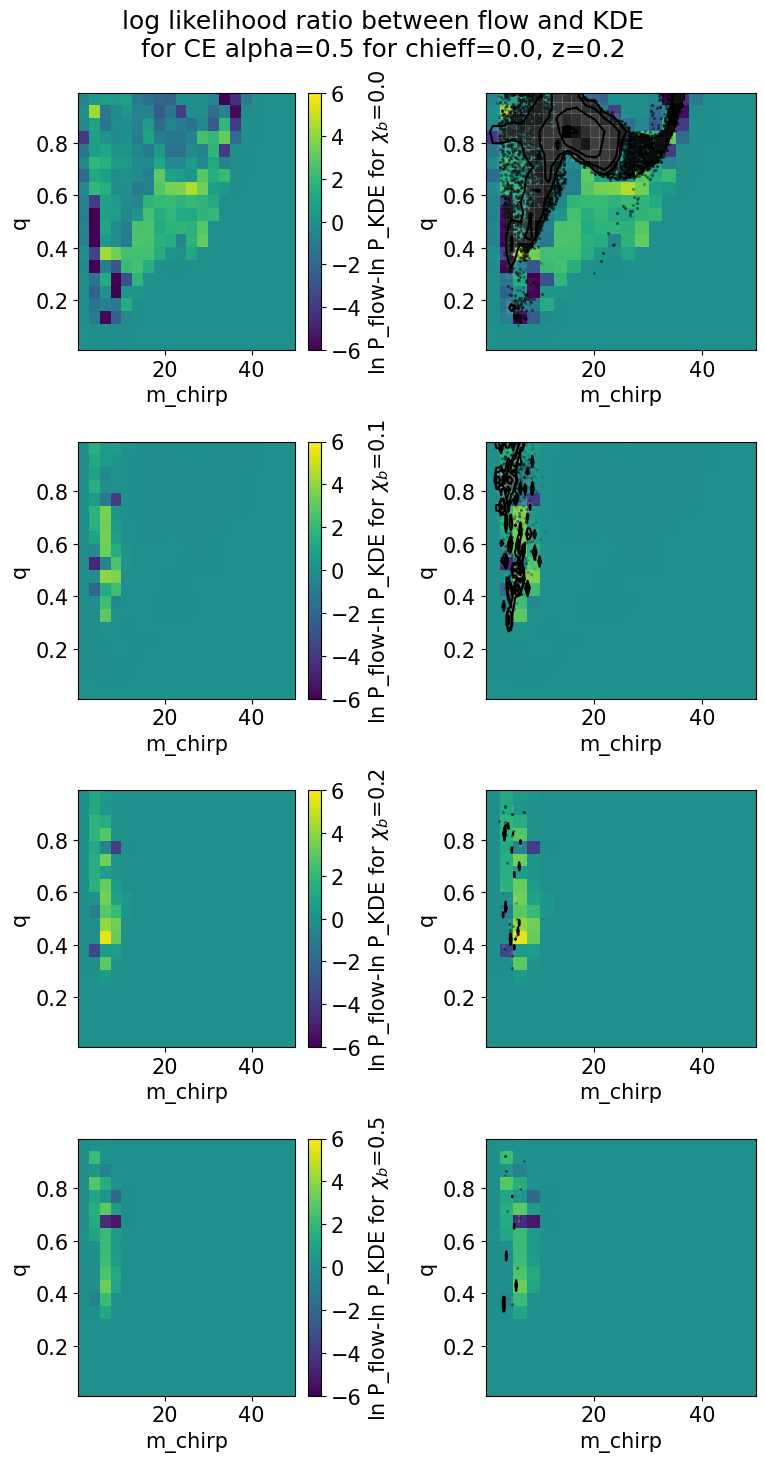

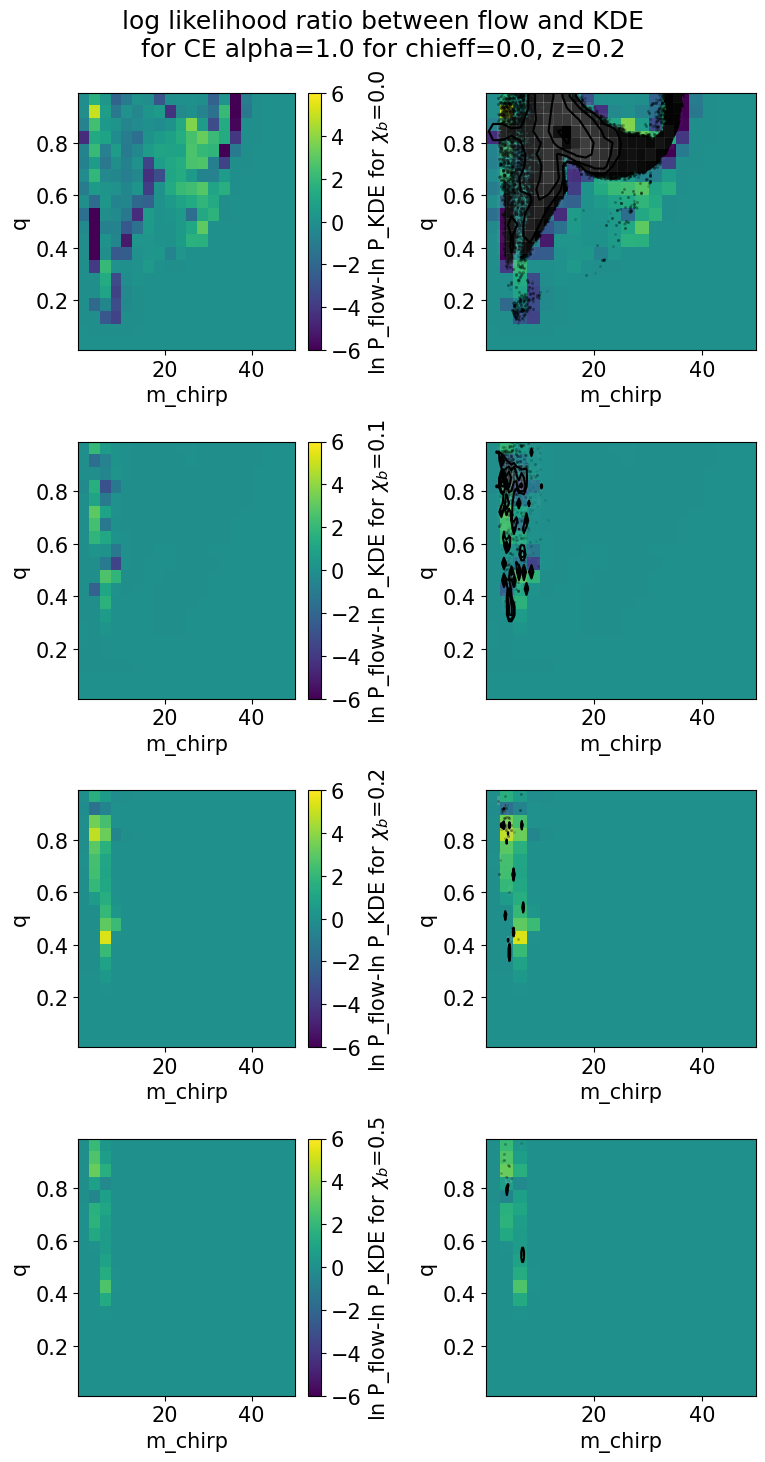

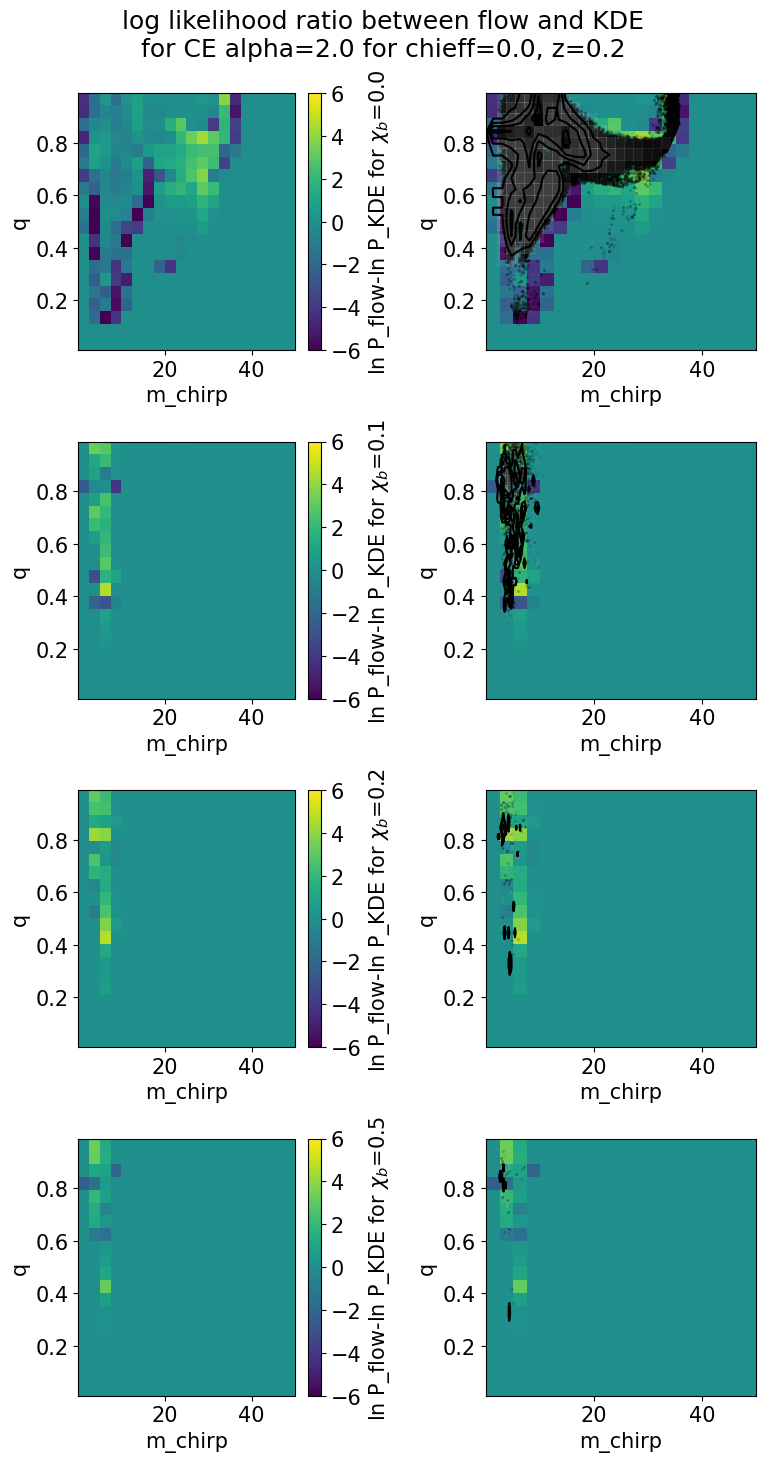

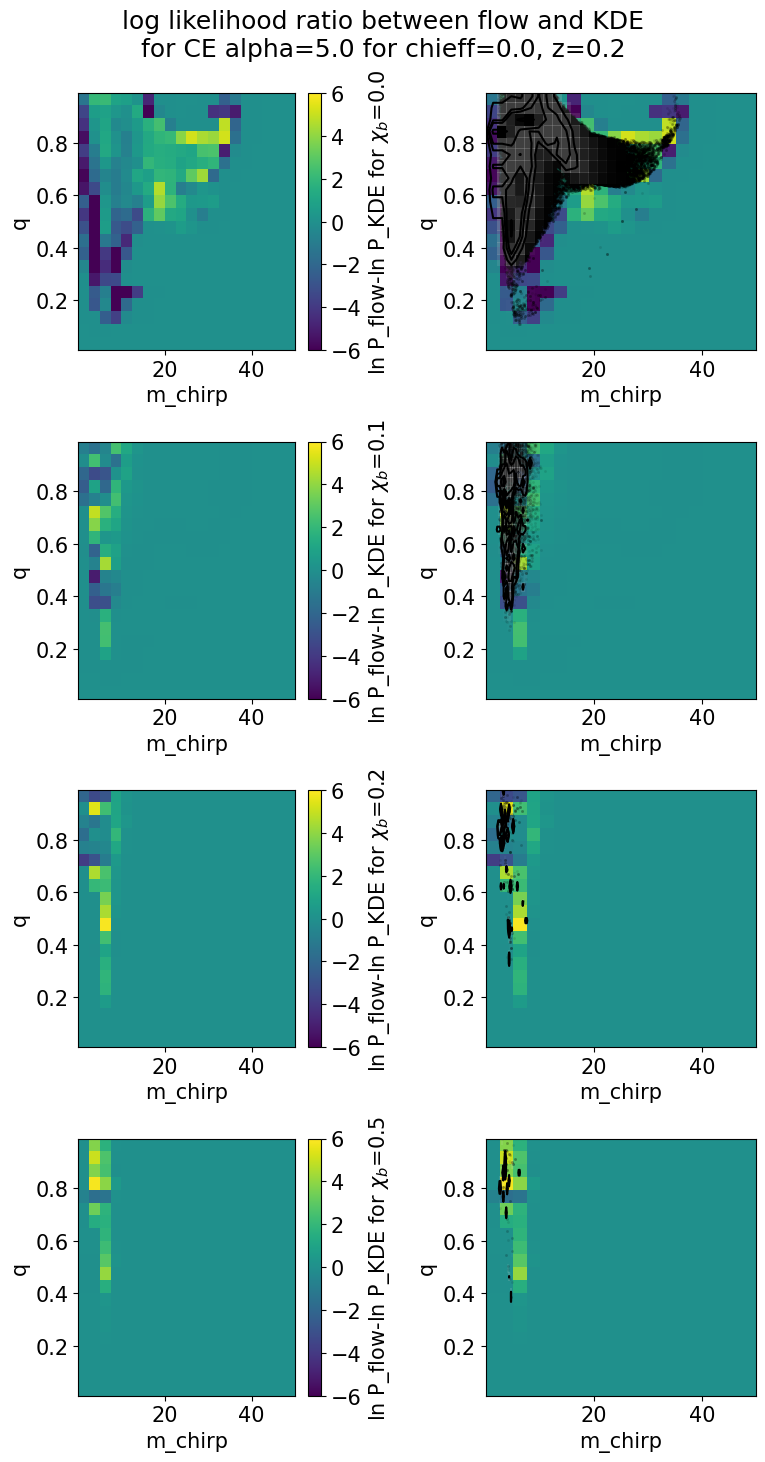

In [50]:
plt.rcParams["figure.figsize"] = (8,15)
plt.rcParams.update({'font.size': 15})

for alphaid in range(5):
    fig, ax = plt.subplots(4,2)
    for chibid in range(4):
        ratio = p_mchirpq[chibid, alphaid,:,:]-p_mchirpq_kde[chibid, alphaid,:,:]
        #oldratio = strict_reg_flow[chibid, alphaid,:,:]-strct_reg_KDE[chibid, alphaid,:,:]
        c = ax[chibid,0].imshow(np.swapaxes(ratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')
        cbar = fig.colorbar(c, ax=ax[chibid,0])
        cbar.set_label(fr'ln P_flow-ln P_KDE for $\chi_b$={chi_b[chibid]}')
        #c = ax[chibid,1].imshow(np.swapaxes(oldratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')


        ax[chibid,0].set_xlabel(fr'm_chirp')
        ax[chibid,1].set_xlabel(fr'm_chirp')
        ax[chibid,0].set_ylabel(fr'q')

        bin_width = 0.05
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
        bin_z = np.logical_and(zs>0.2 - 10*bin_width, zs < 0.2 + 10*bin_width)
        bin_conditions = np.logical_and(bin_chieff, bin_z)

        c = ax[chibid,1].imshow(np.swapaxes(ratio,0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto', zorder=-200)

        corner.hist2d(np.array(models_dict[(chibid,alphaid)][bin_conditions]['mchirp']), np.array(models_dict[(chibid,alphaid)][bin_conditions]['q']),\
             weights=np.array(weights_dict[(chibid,alphaid)][bin_conditions]), alpha=0.5, density=True, ax=ax[chibid,1], no_fill_contours=True)
        ax[chibid,1].set_xlim(mchirps[0], mchirps[-1])
        ax[chibid,1].set_ylim(qs[0], qs[-1])
        ax[chibid,1].set_xlabel(fr'm_chirp')
        ax[chibid,1].set_ylabel(fr'q')
    fig.suptitle('log likelihood ratio between flow and KDE''\n'fr'for CE alpha={alpha[alphaid]} for chieff=0.0, z=0.2')
    fig.tight_layout(pad=1.3)
    #fig.savefig(f'llh_ratio/slices/CE2Dmchirpq_chi0_z02_alpha{alpha[alphaid]}.pdf')

## Non-CE channels

In [33]:
mchirps = np.linspace(0.1,49.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.0,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps):
    sample[i] = np.asarray([m, 0.8,0.0,0.2])

sample = np.reshape(sample, (1,-1,4))


p_mchirp = np.zeros((4,np.shape(sample)[1]))
for chibid, xb in enumerate(chi_b):
        for i in range(100):
            samplei = np.reshape(sample[:,i,:], (1,1,4))
            p_mchirp[chibid, i] = samp.lnlike([chibid], samplei, flow, submodels_dict, channels, use_flows=True, prior_pdf=None,use_reg=True)

In [31]:
mchirps_kde = np.linspace(0.1,49.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.0,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps_kde):
    sample[i] = np.asarray([m, 0.8,0.0,0.2])

sample = np.reshape(sample, (1,-1,4))

p_mchirp_kde = np.zeros((4,np.shape(sample)[1]))
p_mchirp_kde_hbw = np.zeros((4,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for i in range(100):
        samplei = np.reshape(sample[:,i,:], (1,1,4))
        p_mchirp_kde[chibid, i] = samp.lnlike([chibid], samplei, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True)
        p_mchirp_kde_hbw[chibid, i] = samp.lnlike([chibid], samplei, KDE_halfbw, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True)

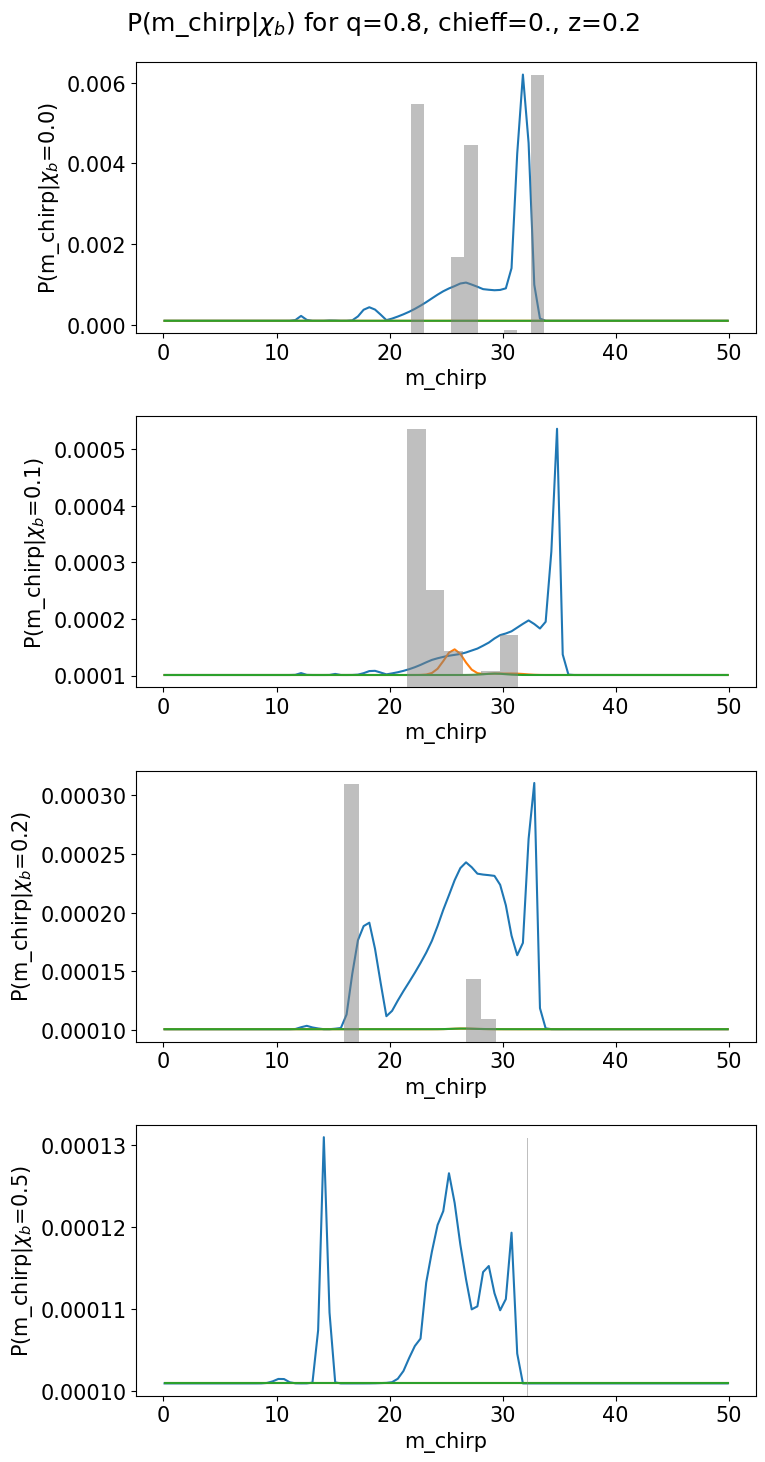

In [34]:
plt.rcParams["figure.figsize"] = (8,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4)

for chibid, xb in enumerate(chi_b):
        ax[chibid].plot(mchirps, np.reshape(np.exp(p_mchirp[chibid]), -1))
        ax[chibid].plot(mchirps_kde, np.reshape(np.exp(p_mchirp_kde[chibid]), -1))
        ax[chibid].plot(mchirps_kde, np.reshape(np.exp(p_mchirp_kde_hbw[chibid]), -1))
        #ax[chibid,alphaid].plot(mchirps, np.reshape(np.exp(p_mchirp[chibid,alphaid]), -1)/np.reshape((p_mchirp_kde[chibid,alphaid]), -1))


        #plot histogram of samples around this point q=0.8,chieff=0.1,z=0.1
        bin_width = 0.06
        qs= models_dict[(chibid)][:]['q']
        chieffs = models_dict[(chibid)][:]['chieff']
        zs = models_dict[(chibid)][:]['z']
        bin_q = np.logical_and(qs>0.8 - bin_width, qs < 0.8 + bin_width)
        bin_chieff = np.logical_and(chieffs>0.1 - 2*bin_width,  chieffs< 0.1 + 2*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_chieff), bin_z)

        secax = ax[chibid].twinx()
        secax.hist(models_dict[(chibid)][bin_conditions]['mchirp'], weights=weights_dict[(chibid)][bin_conditions], color='grey', alpha=0.5, density=True)
        secax.axis('off')

        ax[chibid].set_xlabel(fr'm_chirp')
        ax[chibid].set_ylabel(fr'P(m_chirp|$\chi_b$={xb})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P(m_chirp|$\chi_b$) for q=0.8, chieff=0., z=0.2')
fig_mchirp.tight_layout(pad=1.3)
#fig_mchirp.savefig('llh_ratio/slices/CE1Dmchirp_q08_chi01_z01.pdf')

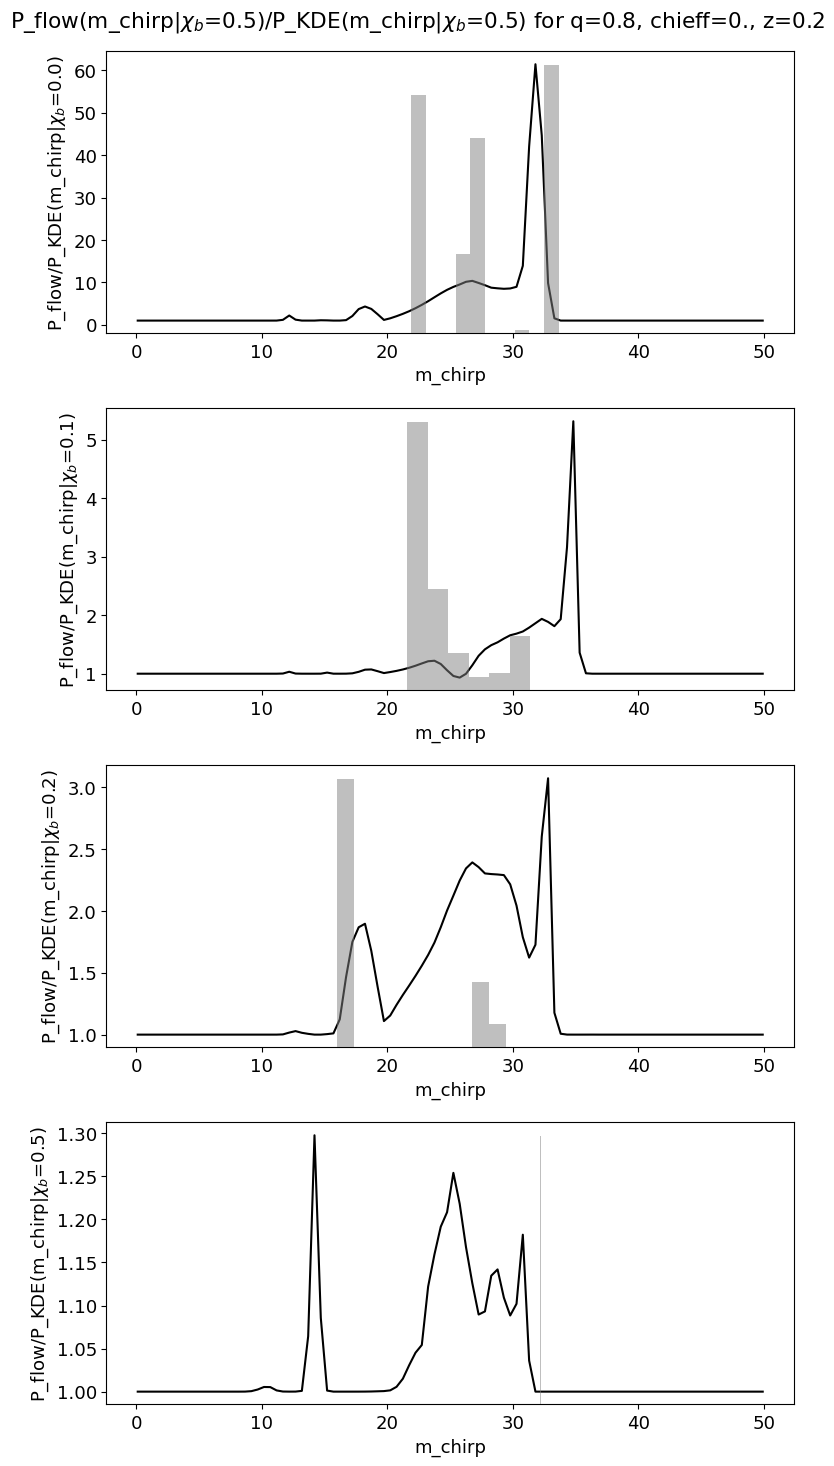

In [11]:
plt.rcParams["figure.figsize"] = (8,15)
plt.rcParams.update({'font.size': 13})
fig_mchirp, ax = plt.subplots(4)

for chibid, xb in enumerate(chi_b):
        ax[chibid].plot(mchirps, np.reshape(np.exp(p_mchirp[chibid]), -1)/np.reshape(np.exp(p_mchirp_kde[chibid]), -1), color='black')

        #plot histogram of samples around this point q=0.8,chieff=0.1,z=0.1
        bin_width = 0.06
        qs= models_dict[(chibid)][:]['q']
        chieffs = models_dict[(chibid)][:]['chieff']
        zs = models_dict[(chibid)][:]['z']
        bin_q = np.logical_and(qs>0.8 - bin_width, qs < 0.8 + bin_width)
        bin_chieff = np.logical_and(chieffs>0.1 - 2*bin_width,  chieffs< 0.1 + 2*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_chieff), bin_z)

        secax = ax[chibid].twinx()
        secax.hist(models_dict[(chibid)][bin_conditions]['mchirp'], weights=weights_dict[(chibid)][bin_conditions], color='grey', alpha=0.5, density=True)
        secax.axis('off')

        ax[chibid].set_xlabel(fr'm_chirp')
        ax[chibid].set_ylabel(fr'P_flow/P_KDE(m_chirp|$\chi_b$={xb})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P_flow(m_chirp|$\chi_b$={xb})/P_KDE(m_chirp|$\chi_b$={xb}) for q=0.8, chieff=0., z=0.2')
fig_mchirp.tight_layout(pad=1.3)
#fig_mchirp.savefig('llh_ratio/slices/CE1Dmchirp_q08_chi01_z01.pdf')

In [17]:
mchirps = np.linspace(0.1,49.9,20)
qs = np.linspace(0.01,0.99,20)

p_mchirpq = np.zeros((4,20,20))
p_mchirpq_kde = np.zeros((4,20,20))
p_mchirpq_kde_hbw = np.zeros((4,20,20))

for chibid, xb in enumerate(chi_b):
    for  i, m in enumerate(mchirps):
        for j, q in enumerate(qs):
            sample = np.reshape([m, q,0.0,0.2], (1,1,4))
            p_mchirpq[chibid, i, j] = samp.lnlike([chibid], sample, flow, submodels_dict, channels, use_flows=True, prior_pdf=None, use_reg=True, smallest_n=10)
            p_mchirpq_kde[chibid, i, j] = samp.lnlike([chibid], sample, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True, smallest_n=10)
            #p_mchirpq_kde_hbw[chibid, i, j] = samp.lnlike([chibid], sample, KDE_halfbw, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True)

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

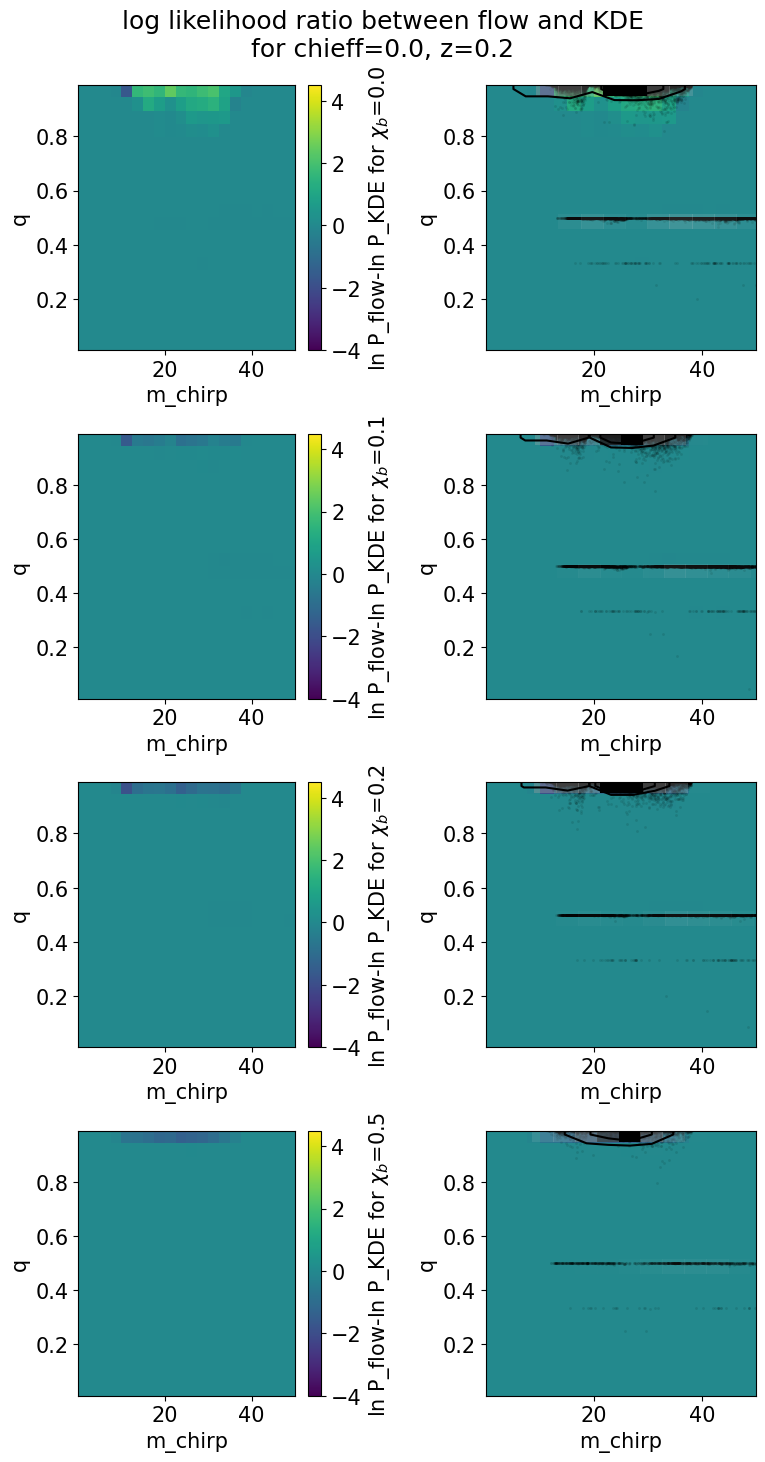

In [18]:
plt.rcParams["figure.figsize"] = (8,15)
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(4,2)
for chibid in range(4):
    ratio = p_mchirpq[chibid,:,:]-p_mchirpq_kde[chibid,:,:]
    c = ax[chibid,0].imshow(np.swapaxes(ratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-4, vmax=4.5, aspect='auto')
    cbar = fig_mchirp.colorbar(c, ax=ax[chibid,0])
    cbar.set_label(fr'ln P_flow-ln P_KDE for $\chi_b$={chi_b[chibid]}')

    ax[chibid,0].set_xlabel(fr'm_chirp')
    ax[chibid,0].set_ylabel(fr'q')

    bin_width = 0.05
    chieffs = models_dict[(chibid)][:]['chieff']
    zs = models_dict[(chibid)][:]['z']
    bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
    bin_z = np.logical_and(zs>0.2 - 10*bin_width, zs < 0.2 + 10*bin_width)
    bin_conditions = np.logical_and(bin_chieff, bin_z)

    c = ax[chibid,1].imshow(np.swapaxes(ratio,0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-4, vmax=4.5, aspect='auto', zorder=-200)

    corner.hist2d(np.array(models_dict[(chibid)][bin_conditions]['mchirp']), np.array(models_dict[(chibid)][bin_conditions]['q']),\
            weights=np.array(weights_dict[(chibid)][bin_conditions]), alpha=0.5, density=True, ax=ax[chibid,1], no_fill_contours=True)
    ax[chibid,1].set_xlim(mchirps[0], mchirps[-1])
    ax[chibid,1].set_ylim(qs[0], qs[-1])
    ax[chibid,1].set_xlabel(fr'm_chirp')
    ax[chibid,1].set_ylabel(fr'q')
fig.suptitle('log likelihood ratio between flow and KDE''\n''for chieff=0.0, z=0.2')
fig.tight_layout(pad=1.3)
#fig.savefig(f'llh_ratio/slices/CE2Dmchirpq_chi0_z02_alpha{alpha[alphaid]}.pdf')

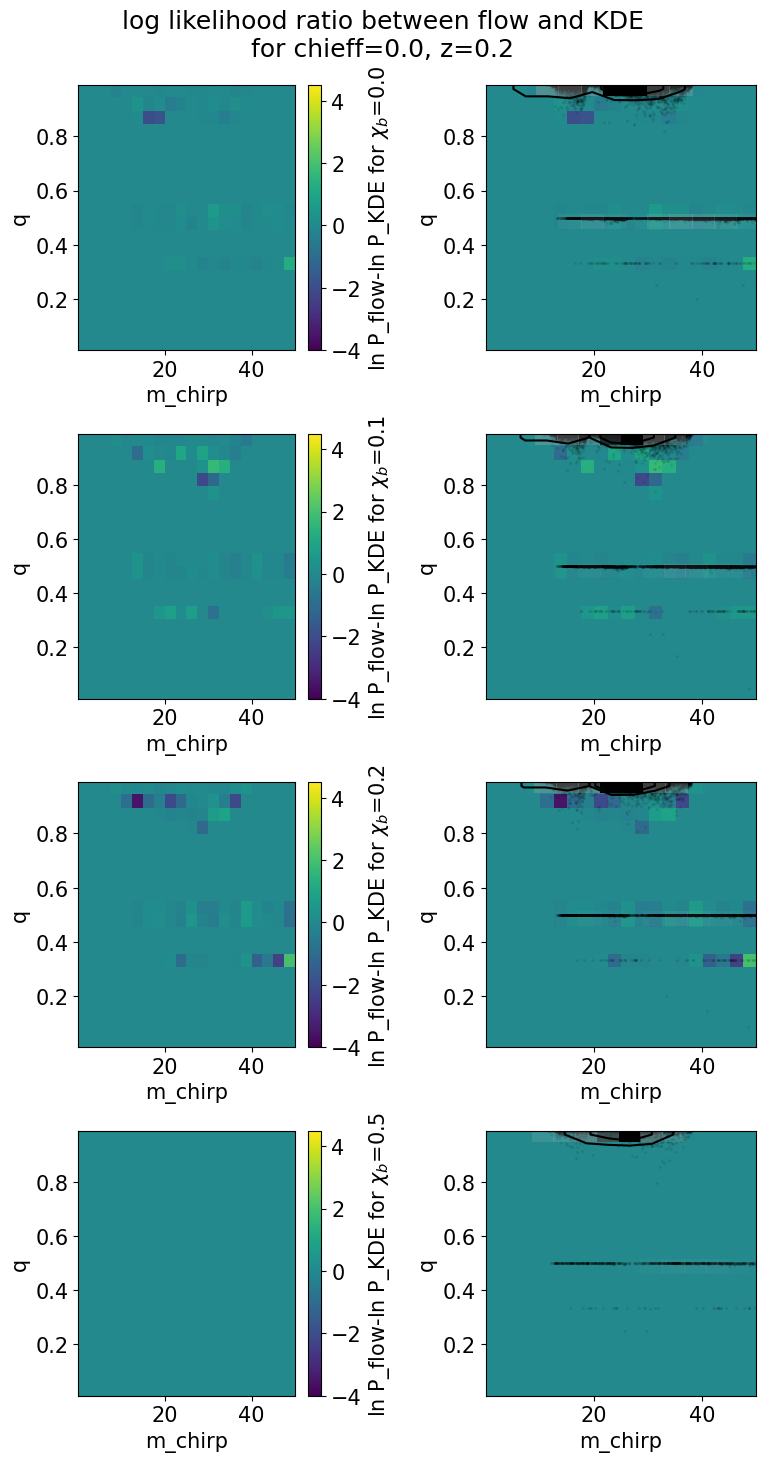

In [36]:
plt.rcParams["figure.figsize"] = (8,15)
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(4,2)
for chibid in range(4):
    ratio = p_mchirpq_kde[chibid,:,:]-p_mchirpq_kde_hbw[chibid,:,:]
    c = ax[chibid,0].imshow(np.swapaxes(ratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-4, vmax=4.5, aspect='auto')
    cbar = fig_mchirp.colorbar(c, ax=ax[chibid,0])
    cbar.set_label(fr'ln P_flow-ln P_KDE for $\chi_b$={chi_b[chibid]}')

    ax[chibid,0].set_xlabel(fr'm_chirp')
    ax[chibid,0].set_ylabel(fr'q')

    bin_width = 0.05
    chieffs = models_dict[(chibid)][:]['chieff']
    zs = models_dict[(chibid)][:]['z']
    bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
    bin_z = np.logical_and(zs>0.2 - 10*bin_width, zs < 0.2 + 10*bin_width)
    bin_conditions = np.logical_and(bin_chieff, bin_z)

    c = ax[chibid,1].imshow(np.swapaxes(ratio,0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-4, vmax=4.5, aspect='auto', zorder=-200)

    corner.hist2d(np.array(models_dict[(chibid)][bin_conditions]['mchirp']), np.array(models_dict[(chibid)][bin_conditions]['q']),\
            weights=np.array(weights_dict[(chibid)][bin_conditions]), alpha=0.5, density=True, ax=ax[chibid,1], no_fill_contours=True)
    ax[chibid,1].set_xlim(mchirps[0], mchirps[-1])
    ax[chibid,1].set_ylim(qs[0], qs[-1])
    ax[chibid,1].set_xlabel(fr'm_chirp')
    ax[chibid,1].set_ylabel(fr'q')
fig.suptitle('log likelihood ratio between flow and KDE''\n''for chieff=0.0, z=0.2')
fig.tight_layout(pad=1.3)
#fig.savefig(f'llh_ratio/slices/CE2Dmchirpq_chi0_z02_alpha{alpha[alphaid]}.pdf')

## 4D plot of ratio

In [18]:
mchirps = np.linspace(0.1,65.,10)
qs = np.linspace(0.01,0.99,10)
chieffs = np.linspace(-0.5,0.99,10)
zs = np.linspace(0.01,6.,10)

p_mchirpqchiz = np.zeros((4,10,10,10,10))
p_mchirpqchiz_kde = np.zeros((4,10,10,10,10))

for chibid, xb in enumerate(chi_b):
    for  i, m in enumerate(mchirps):
        for j, q in enumerate(qs):
            for  x, chi in enumerate(chieffs):
                for y, z in enumerate(zs):
                    sample = np.reshape([m, q, chi, z], (1,1,4))
                    p_mchirpqchiz[chibid, i, j, x, y] = samp.lnlike([chibid], sample, flow, submodels_dict, channels, use_flows=True, prior_pdf=None, use_reg=True)
                    p_mchirpqchiz_kde[chibid, i, j, x, y] = samp.lnlike([chibid], sample, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True)

In [28]:
np.save('llh_ratio/slices/NSC4Dllh_flows_150124_extralong.pdf', p_mchirpqchiz)
np.save('llh_ratio/slices/NSC4Dllh_KDEs.pdf', p_mchirpqchiz_kde)


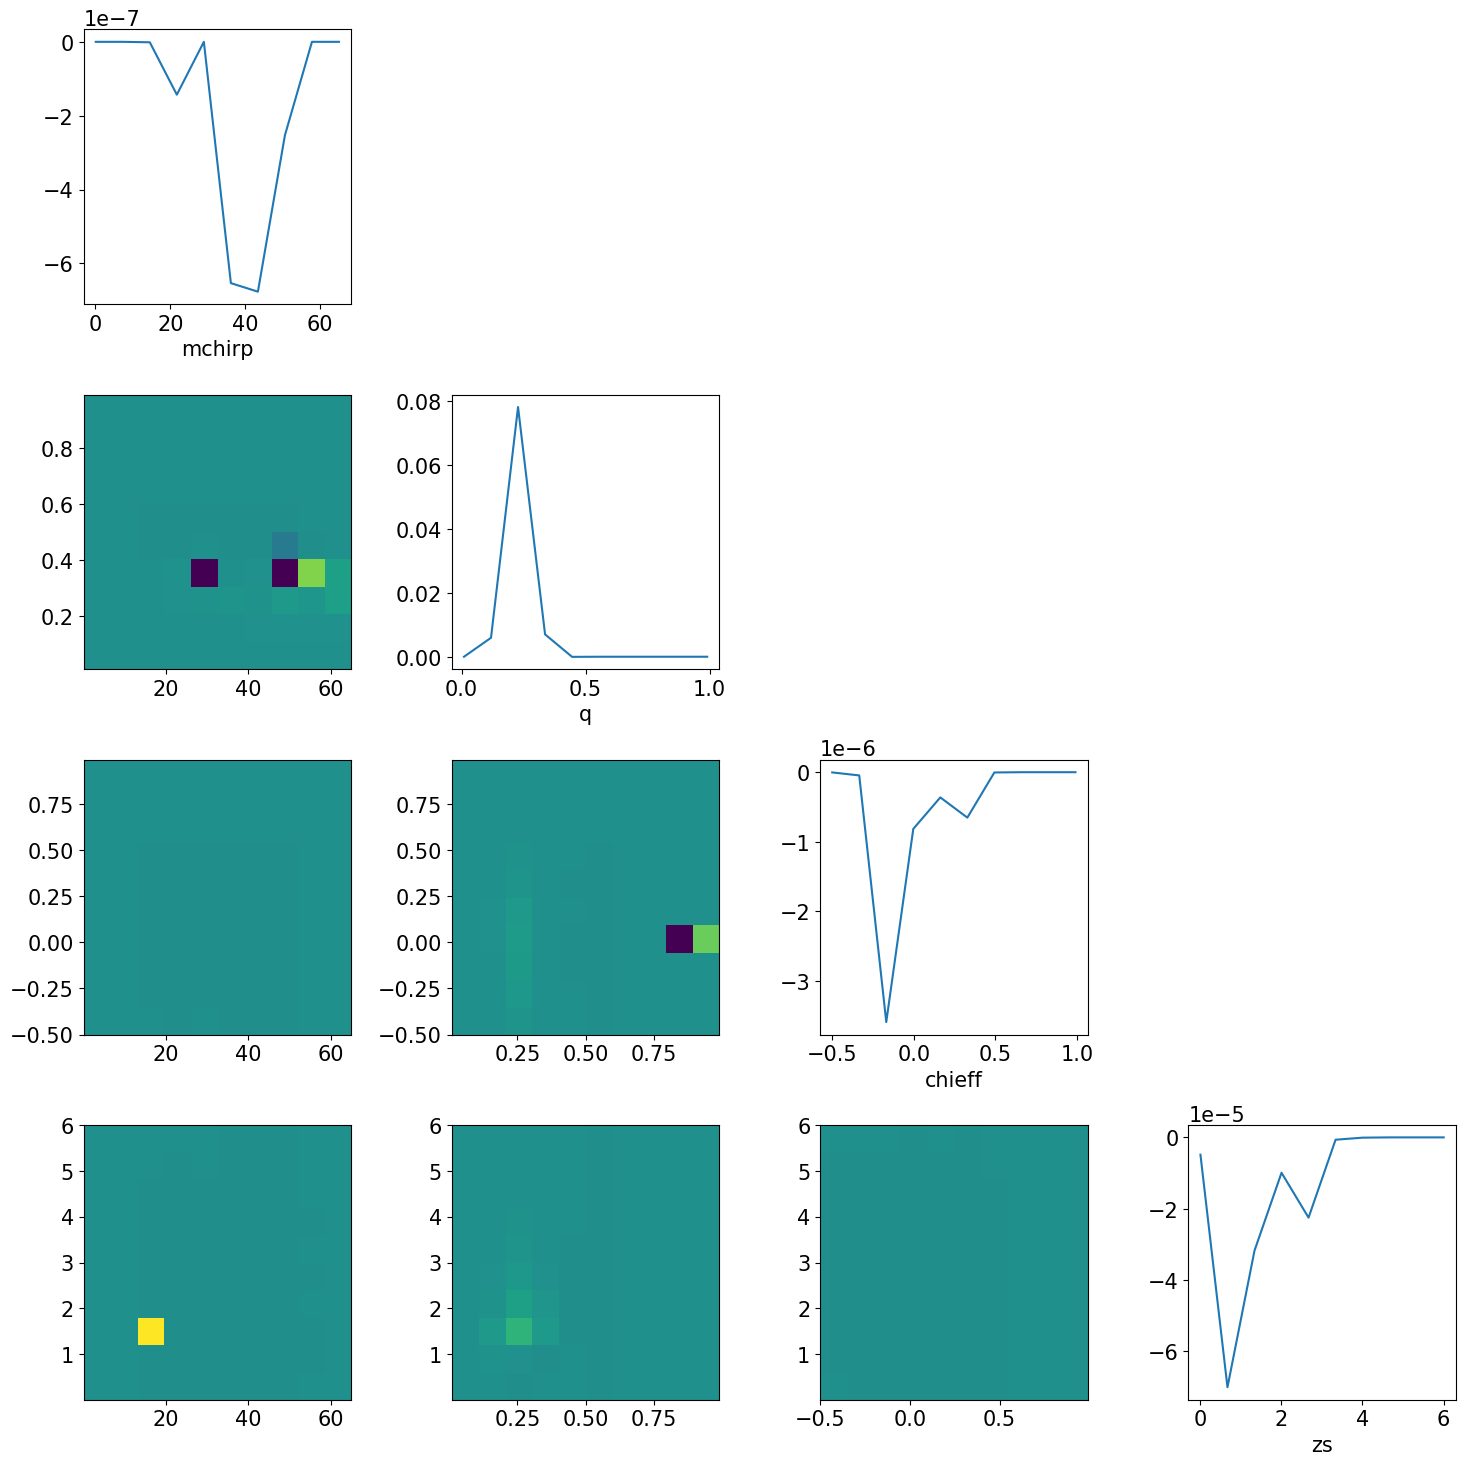

In [29]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(4,4)
chibid = 0


ratio = p_mchirpqchiz[chibid,:,:,:,:]-p_mchirpqchiz_kde[chibid,:,:,:,:]
ax[0,0].plot(mchirps, ratio[:, 5, 5, 5])
ax[0,0].set_xlabel('mchirp')
ax[1,1].plot(qs, ratio[5, :, 5, 5])
ax[1,1].set_xlabel('q')
ax[2,2].plot(chieffs, ratio[5, 5, :, 5])
ax[2,2].set_xlabel('chieff')
ax[3,3].plot(zs, ratio[5, 5, 5, :])
ax[3,3].set_xlabel('zs')

ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()
ax[0,3].set_axis_off()
ax[1,3].set_axis_off()
ax[2,3].set_axis_off()

cbarmin=2

c = ax[1,0].imshow(np.swapaxes(ratio[:,:,5,5], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[2,0].imshow(np.swapaxes(ratio[:,5,:,5], 0,1), extent=(mchirps[0], mchirps[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[2,1].imshow(np.swapaxes(ratio[5,:,:,5], 0,1), extent=(qs[0], qs[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,0].imshow(np.swapaxes(ratio[:,5,5,:], 0,1), extent=(mchirps[0], mchirps[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[3,1].imshow(np.swapaxes(ratio[5,:,5,:], 0,1), extent=(qs[0], qs[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,2].imshow(np.swapaxes(ratio[5,5,:,:], 0,1), extent=(chieffs[0], chieffs[-1], zs[0], zs[-1], ), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')


fig.tight_layout(pad=1.3)

#cbar = fig.colorbar(c, ax=ax[1,0])

In [23]:
np.max(ratio[:,:,:,:])

4.49845994218054